__Задание:__

Есть три набора данных с информацией от датчиков (см. вложение) с оборудования.
Датчики фиксируют физические показатели (время, давление, скорость и др.). 
Одна колонка - один физический показатель.
Ответьте на вопросы ниже.
 
1. Опишите, какие действия вы бы выполнили с этими наборами данных, чтобы их можно было использовать для обучения моделей?

2. В данных файлах единицы в поле StuckPipe означают близость к аварии (при этом они отмечают как аварию, так и несколько секунд до и после нее).
Видно, что в данном поле есть переизбыток данных одного типа и недостаток другого.
Как повлияет данная ситуация на точность прогноза моделей? 
Чтобы вы сделали, чтобы повысить точность? Приведите пример кода.

3. Как вы бы прогнозировали на основе этих данных вероятность аварии в следующую минуту? 5 минут? час?

## Задание 1
Для того, чтобы использовать имеющиеся наборы данных для обучения модели нужно как минимум сделать разведывательный анализ данных (EDA) и попробовать feature engineering

Чтение данных и импорт нужных библиотек:

In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np
sns.set(style="darkgrid")
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

import warnings
warnings.filterwarnings('ignore')

import datacompy

import imblearn
from collections import Counter
from numpy import where
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from numpy import mean

#сразу уберем 2 строку, где информация о единицах измерения и т.д.
df1 = pd.read_excel('241-1.xlsx', skiprows=[1])
df2 = pd.read_excel('220ST3-1.xlsx', skiprows=[1])
df3 = pd.read_excel('216-1.xlsx', skiprows=[1])

### Осмотр данных

In [230]:
display(df1.head(10))
df1.info()

,Date/Time,StuckPipe,TVD,DEPT,CDEPTH,HDTH,BPOS,HKLD,STOR,FLWI,RPM,SPPA,ECD,DLS,INCL,AZIM,GR,APRS,BVEL,RIG_STATE,Stick_Slip_Ratio,StickPercentage,ESD
0,2012-05-03 09:15:00,NaN,1121.6945,4765.6821,4765.6821,6654.9971,22.4607,59.4070,30.78,4002.3162,81.56,22020.4766,-999.2500,0.0492,82.68,86.80,-999.25,-999.2500,-35.1472,7,-999.2500,-999.2500,-999.25
1,2012-05-03 09:15:10,NaN,1121.6792,4765.5723,4765.5723,6654.9971,22.5674,59.9649,30.60,4006.0259,81.56,22030.4043,1.4271,0.0492,82.69,86.80,139.41,15644.2041,-39.5407,7,-999.2500,-999.2500,-999.25
2,2012-05-03 09:15:20,NaN,1121.6670,4765.4717,4765.4717,6654.9971,22.6680,59.4932,31.44,4003.1868,81.56,22038.9531,-999.2500,0.0492,82.69,86.81,145.60,-999.2500,-36.2188,7,-999.2500,-999.2500,-999.25
3,2012-05-03 09:15:30,NaN,1121.6549,4765.3711,4765.3711,6654.9971,22.7686,59.1394,30.77,4003.0732,81.56,22029.5762,-999.2500,0.0492,82.69,86.81,-999.25,-999.2500,-36.2188,7,-999.2500,-999.2500,-999.25
4,2012-05-03 09:15:40,NaN,1121.6396,4765.2646,4765.2646,6654.9971,22.8783,58.5406,30.80,4006.4043,81.56,22024.0605,-999.2500,0.0492,82.69,86.81,145.60,-999.2500,-38.3619,7,-999.2500,-999.2500,-999.25
5,2012-05-03 09:15:50,NaN,1121.6274,4765.1641,4765.1641,6654.9971,22.9789,58.9579,30.35,4006.8965,81.56,22012.9609,-999.2500,0.0492,82.69,86.81,-999.25,-999.2500,-36.2188,7,9.1957,9.1957,-999.25
6,2012-05-03 09:16:00,NaN,1121.6152,4765.0571,4765.0571,6654.9971,23.0856,58.5452,30.02,4005.2310,81.55,22010.6855,-999.2500,0.0492,82.69,86.81,118.79,-999.2500,-38.4691,7,-999.2500,-999.2500,-999.25
7,2012-05-03 09:16:10,NaN,1121.6030,4764.9629,4764.9629,6654.9971,23.1800,58.9942,30.30,4003.3381,81.55,22024.2676,1.4259,0.0492,82.69,86.81,-999.25,15637.3096,-33.9685,7,-999.2500,-999.2500,-999.25
8,2012-05-03 09:16:20,NaN,1121.5908,4764.8623,4764.8623,6654.9971,23.2806,58.9443,30.95,4002.4675,81.56,22040.4707,-999.2500,0.0492,82.69,86.81,130.37,-999.2500,-36.2188,7,-999.2500,-999.2500,-999.25
9,2012-05-03 09:16:30,NaN,1121.5756,4764.7524,4764.7524,6654.9971,23.3873,59.2165,31.07,4005.0037,81.56,22022.1992,-999.2500,0.0492,82.69,86.81,-999.25,-999.2500,-39.5407,7,-999.2500,-999.2500,-999.25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date/Time         248 non-null    datetime64[ns]
 1   StuckPipe         9 non-null      float64       
 2   TVD               248 non-null    float64       
 3   DEPT              248 non-null    float64       
 4   CDEPTH            248 non-null    float64       
 5   HDTH              248 non-null    float64       
 6   BPOS              248 non-null    float64       
 7   HKLD              248 non-null    float64       
 8   STOR              248 non-null    float64       
 9   FLWI              248 non-null    float64       
 10  RPM               248 non-null    float64       
 11  SPPA              248 non-null    float64       
 12  ECD               248 non-null    float64       
 13  DLS               248 non-null    float64       
 14  INCL              248 non-

In [231]:
display(df2.head(10))
df2.info()

,Date/Time,StuckPipe,TVD,DEPT,CDEPTH,HDTH,BPOS,HKLD,STOR,FLWI,RPM,SPPA,ECD,DLS,INCL,AZIM,GR,APRS,BVEL,RIG_STATE,Stick_Slip_Ratio,StickPercentage,ESD
0,2015-05-09 12:40:00,NaN,1677.2717,4954.5791,4954.5576,5565.0049,1.4722,60.1282,40.2814,1628.7114,74.46,155.3401,-999.2500,1.7618,93.96,24.75,78.96,-999.2500,-92.1167,7,-999.25,-999.25,-999.25
1,2015-05-09 12:40:10,NaN,1677.3296,4953.7437,4953.7866,5565.0049,2.2647,64.3149,40.1322,1625.9102,73.95,156.7398,-999.2500,1.7618,94.01,24.73,78.18,-999.2500,-306.6258,7,-999.25,-999.25,-999.25
2,2015-05-09 12:40:20,NaN,1677.3479,4953.4570,4953.4082,5565.0049,2.6121,59.8107,36.5393,1628.8628,81.61,157.7625,-999.2500,1.7618,94.02,24.72,75.84,-999.2500,0.0000,7,-999.25,-999.25,-999.25
3,2015-05-09 12:40:30,NaN,1677.3845,4952.9697,4952.9697,5565.0049,3.0785,64.1198,40.8779,1628.5978,81.73,159.3936,-999.2500,1.7618,94.05,24.71,74.26,-999.2500,-319.7108,7,-999.25,-999.25,-999.25
4,2015-05-09 12:40:40,NaN,1677.4454,4952.0825,4952.0825,5565.0049,3.9685,63.3669,39.7390,1624.6610,81.75,158.5580,-999.2500,1.7618,94.09,24.68,73.23,-999.2500,-318.0710,7,-999.25,-999.25,-999.25
5,2015-05-09 12:40:50,NaN,1677.5095,4951.1924,4951.1924,5565.0049,4.8555,63.1900,38.4374,1627.0458,81.56,158.0782,-999.2500,1.7618,94.14,24.66,76.24,-999.2500,-322.8350,7,-999.25,-999.25,-999.25
6,2015-05-09 12:41:00,NaN,1677.5735,4950.3057,4950.3481,5565.0049,5.6998,64.3103,41.2169,1624.6610,81.51,159.3228,-999.2500,1.7618,94.18,24.63,81.51,-999.2500,-319.5127,7,-999.25,-999.25,-999.25
7,2015-05-09 12:41:10,NaN,1677.6405,4949.4155,4949.4155,5565.0049,6.6324,63.6027,39.1018,1628.8628,81.65,158.4818,-999.2500,1.7618,94.23,24.61,82.66,-999.2500,-322.3839,7,-999.25,-999.25,-999.25
8,2015-05-09 12:41:20,NaN,1677.7046,4948.5288,4948.5742,5565.0049,7.4737,64.0699,40.5118,1628.8628,81.60,158.7179,1.5134,1.7618,94.27,24.58,81.34,245.5098,-325.8860,7,-999.25,-999.25,-999.25
9,2015-05-09 12:41:30,NaN,1677.7716,4947.6416,4947.6416,5565.0049,8.4064,64.0427,42.8303,1628.1814,81.62,158.7444,-999.2500,1.7618,94.32,24.56,77.88,-999.2500,-323.3136,7,-999.25,-999.25,-999.25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date/Time         189 non-null    datetime64[ns]
 1   StuckPipe         9 non-null      float64       
 2   TVD               189 non-null    float64       
 3   DEPT              189 non-null    float64       
 4   CDEPTH            189 non-null    float64       
 5   HDTH              189 non-null    float64       
 6   BPOS              189 non-null    float64       
 7   HKLD              189 non-null    float64       
 8   STOR              189 non-null    float64       
 9   FLWI              189 non-null    float64       
 10  RPM               189 non-null    float64       
 11  SPPA              189 non-null    float64       
 12  ECD               189 non-null    float64       
 13  DLS               189 non-null    float64       
 14  INCL              189 non-

In [232]:
display(df3.head(10))
df3.info()

,Date/Time,StuckPipe,TVD,DEPT,CDEPTH,HDTH,BPOS,HKLD,STOR,FLWI,RPM,SPPA,ECD,DLS,INCL,AZIM,GR,APRS,BVEL,RIG_STATE,Stick_Slip_Ratio,StickPercentage,ESD
0,2012-12-13 10:00:00,NaN,-999.25,4634.1001,-999.25,5669.0664,31.4797,57.5518,1.92,0.0,-1.07,60.1471,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,12,-999.25,-999.25,-999.25
1,2012-12-13 10:00:30,NaN,-999.25,4634.1670,-999.25,5669.0664,31.4096,13.0272,0.00,0.0,0.28,23.5104,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,2,-999.25,-999.25,-999.25
2,2012-12-13 10:01:00,NaN,-999.25,4634.1670,-999.25,5669.0664,31.4096,13.3991,0.00,0.0,0.28,21.4310,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,2,-999.25,-999.25,-999.25
3,2012-12-13 10:01:30,NaN,-999.25,4634.1670,-999.25,5669.0664,31.4096,11.1947,0.02,0.0,0.24,19.2598,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,2,-999.25,-999.25,-999.25
4,2012-12-13 10:02:00,NaN,-999.25,4634.1670,-999.25,5669.0664,31.4188,12.1744,-0.01,0.0,0.37,15.5608,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,2,-999.25,-999.25,-999.25
5,2012-12-13 10:02:30,NaN,-999.25,4634.1670,-999.25,5669.0664,31.4310,13.8119,1.07,0.0,-12.49,9.9167,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,2,-999.25,-999.25,-999.25
6,2012-12-13 10:03:00,NaN,-999.25,4634.1670,-999.25,5669.0664,31.4950,14.9958,-0.01,0.0,0.22,5.1993,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,2,-999.25,-999.25,-999.25
7,2012-12-13 10:03:30,NaN,-999.25,4634.1670,-999.25,5669.0664,31.4950,14.6465,2.17,0.0,-12.98,3.9576,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,2,-999.25,-999.25,-999.25
8,2012-12-13 10:04:00,NaN,-999.25,4634.1670,-999.25,5669.0664,31.5377,13.7212,-0.01,0.0,0.30,3.6818,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,2,-999.25,-999.25,-999.25
9,2012-12-13 10:04:30,NaN,-999.25,4634.1670,-999.25,5669.0664,31.2146,17.3227,-0.01,0.0,0.33,3.6066,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,2,-999.25,-999.25,-999.25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date/Time         73 non-null     datetime64[ns]
 1   StuckPipe         5 non-null      float64       
 2   TVD               73 non-null     float64       
 3   DEPT              73 non-null     float64       
 4   CDEPTH            73 non-null     float64       
 5   HDTH              73 non-null     float64       
 6   BPOS              73 non-null     float64       
 7   HKLD              73 non-null     float64       
 8   STOR              73 non-null     float64       
 9   FLWI              73 non-null     float64       
 10  RPM               73 non-null     float64       
 11  SPPA              73 non-null     float64       
 12  ECD               73 non-null     float64       
 13  DLS               73 non-null     float64       
 14  INCL              73 non-nul

Датасеты состоит из данных от датчиков (248, 189 и 73 наблюдения соответственно) с оборудования. Датчики фиксируют физические показатели (время, давление, скорость и др.)., в датасетах по 23 колонки, 22 из которых числовые и 1 - дата/время. Во всех столбцах, кроме StuckPipe, отсутствуют пустые значения. Нужно будет проверить, как заполнить пропуски.

посмотрим, совпадают ли колонки в датасетах

In [190]:
set(df1.columns) - set(df2.columns)

set()

In [191]:
set(df2.columns) - set(df3.columns)

set()

набор столбцов совпадает, но воспользуемся datacompy для более подробного сравнения

In [199]:
df1.columns

Index(['date/time', 'stuckpipe', 'tvd', 'dept', 'cdepth', 'hdth', 'bpos',
       'hkld', 'stor', 'flwi', 'rpm', 'sppa', 'ecd', 'dls', 'incl', 'azim',
       'gr', 'aprs', 'bvel', 'rig_state', 'stick_slip_ratio',
       'stickpercentage', 'esd'],
      dtype='object')

In [207]:
compare = datacompy.Compare(
df1,
df2,
join_columns=['date/time', 'stuckpipe', 'tvd', 'dept', 'cdepth', 'hdth', 'bpos',
       'hkld', 'stor', 'flwi', 'rpm', 'sppa', 'ecd', 'dls', 'incl', 'azim',
       'gr', 'aprs', 'bvel', 'rig_state', 'stick_slip_ratio',
       'stickpercentage', 'esd']
)

In [208]:
print(compare.report())

DataComPy Comparison
--------------------

DataFrame Summary
-----------------

  DataFrame  Columns  Rows
0       df1       23   248
1       df2       23   189

Column Summary
--------------

Number of columns in common: 23
Number of columns in df1 but not in df2: 0
Number of columns in df2 but not in df1: 0

Row Summary
-----------

Matched on: date/time, stuckpipe, tvd, dept, cdepth, hdth, bpos, hkld, stor, flwi, rpm, sppa, ecd, dls, incl, azim, gr, aprs, bvel, rig_state, stick_slip_ratio, stickpercentage, esd
Any duplicates on match values: No
Absolute Tolerance: 0
Relative Tolerance: 0
Number of rows in common: 0
Number of rows in df1 but not in df2: 248
Number of rows in df2 but not in df1: 189

Number of rows with some compared columns unequal: 0
Number of rows with all compared columns equal: 0

Column Comparison
-----------------

Number of columns compared with some values unequal: 0
Number of columns compared with all values equal: 23
Total number of values which compare une

In [209]:
compare = datacompy.Compare(
df3,
df2,
join_columns=['date/time', 'stuckpipe', 'tvd', 'dept', 'cdepth', 'hdth', 'bpos',
       'hkld', 'stor', 'flwi', 'rpm', 'sppa', 'ecd', 'dls', 'incl', 'azim',
       'gr', 'aprs', 'bvel', 'rig_state', 'stick_slip_ratio',
       'stickpercentage', 'esd']
)

In [210]:
print(compare.report())

DataComPy Comparison
--------------------

DataFrame Summary
-----------------

  DataFrame  Columns  Rows
0       df1       23    73
1       df2       23   189

Column Summary
--------------

Number of columns in common: 23
Number of columns in df1 but not in df2: 0
Number of columns in df2 but not in df1: 0

Row Summary
-----------

Matched on: date/time, stuckpipe, tvd, dept, cdepth, hdth, bpos, hkld, stor, flwi, rpm, sppa, ecd, dls, incl, azim, gr, aprs, bvel, rig_state, stick_slip_ratio, stickpercentage, esd
Any duplicates on match values: No
Absolute Tolerance: 0
Relative Tolerance: 0
Number of rows in common: 0
Number of rows in df1 but not in df2: 73
Number of rows in df2 but not in df1: 189

Number of rows with some compared columns unequal: 0
Number of rows with all compared columns equal: 0

Column Comparison
-----------------

Number of columns compared with some values unequal: 0
Number of columns compared with all values equal: 23
Total number of values which compare uneq

В 3х датасетах названия колонок совпадают, но дубликатов среди данных нет. Есть разница в промежутках времени (10 с, 10с и 30 с) соответственно

In [266]:
df1['Delta'] = df1['Date/Time'].diff()

In [267]:
df1['Delta'].value_counts()

0 days 00:00:10    246
0 days 00:00:20      1
Name: Delta, dtype: int64

In [268]:
df2['Delta'] = df2['Date/Time'].diff()

In [269]:
df2['Delta'].value_counts()

0 days 00:00:10    188
Name: Delta, dtype: int64

In [270]:
df3['Delta'] = df3['Date/Time'].diff()

In [271]:
df3['Delta'].value_counts()

0 days 00:00:30    70
0 days 00:01:00     1
0 days 00:00:00     1
Name: Delta, dtype: int64

In [272]:
df1.drop(['Delta'], axis=1)
df2.drop(['Delta'], axis=1)
df3.drop(['Delta'], axis=1)

,Date/Time,StuckPipe,TVD,DEPT,CDEPTH,HDTH,BPOS,HKLD,STOR,FLWI,RPM,SPPA,ECD,DLS,INCL,AZIM,GR,APRS,BVEL,RIG_STATE,Stick_Slip_Ratio,StickPercentage,ESD
0,2012-12-13 10:00:00,0.0,-999.25,4634.1001,-999.25,5669.0664,31.4797,57.5518,1.92,0.0000,-1.07,60.1471,-999.2500,-999.25,-999.25,-999.25,-999.25,-999.2500,0.0000,12,-999.250,-999.250,-999.25
1,2012-12-13 10:00:30,0.0,-999.25,4634.1670,-999.25,5669.0664,31.4096,13.0272,0.00,0.0000,0.28,23.5104,-999.2500,-999.25,-999.25,-999.25,-999.25,-999.2500,0.0000,2,-999.250,-999.250,-999.25
2,2012-12-13 10:01:00,0.0,-999.25,4634.1670,-999.25,5669.0664,31.4096,13.3991,0.00,0.0000,0.28,21.4310,-999.2500,-999.25,-999.25,-999.25,-999.25,-999.2500,0.0000,2,-999.250,-999.250,-999.25
3,2012-12-13 10:01:30,0.0,-999.25,4634.1670,-999.25,5669.0664,31.4096,11.1947,0.02,0.0000,0.24,19.2598,-999.2500,-999.25,-999.25,-999.25,-999.25,-999.2500,0.0000,2,-999.250,-999.250,-999.25
4,2012-12-13 10:02:00,0.0,-999.25,4634.1670,-999.25,5669.0664,31.4188,12.1744,-0.01,0.0000,0.37,15.5608,-999.2500,-999.25,-999.25,-999.25,-999.25,-999.2500,0.0000,2,-999.250,-999.250,-999.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2012-12-13 10:34:00,1.0,-999.25,4579.2236,-999.25,5669.0664,30.6202,56.6129,23.73,1800.3419,100.14,225.7992,-999.2500,-999.25,-999.25,-999.25,89.53,-999.2500,-372.8070,7,-999.250,-999.250,-999.25
69,2012-12-13 10:34:30,1.0,-999.25,4577.8125,-999.25,5669.0664,31.7602,46.3299,20.19,1801.1747,100.17,226.0288,-999.2500,-999.25,-999.25,-999.25,-999.25,-999.2500,223.2812,7,49.416,49.416,-999.25
70,2012-12-13 10:35:00,1.0,-999.25,4578.2422,-999.25,5669.0664,31.4157,46.0442,13.33,1795.5344,3.18,229.3665,1.5805,-999.25,-999.25,-999.25,-999.25,233.5944,0.0000,4,-999.250,-999.250,-999.25
71,2012-12-13 10:35:00,1.0,-999.25,4578.2422,-999.25,5669.0664,31.4157,50.7434,5.50,1794.4746,-1.22,150.2368,-999.2500,-999.25,-999.25,-999.25,-999.25,-999.2500,0.0000,12,-999.250,-999.250,-999.25


В 3м датасете написание колонок отличается от первых 2х датасетов, сделаем названия везде одинаковыми

In [233]:
df3.columns = ['date/time', 'stuckpipe', 'tvd', 'dept', 'cdepth', 'hdth', 'bpos',
       'hkld', 'stor', 'flwi', 'rpm', 'sppa', 'ecd', 'dls', 'incl', 'azim',
       'gr', 'aprs', 'bvel', 'rig_state', 'stick_slip_ratio',
       'stickpercentage', 'esd']

### Первичный анализ данных в столбцах

Напишем функцию, которая покажет нам распределение признаков, выдаст процент пропусков и покажет выбросы для столбцов, у которых определены значения (но таких признаков нет)

In [241]:
def desription(data, col, boundaries = None):
    print('Столбец', col)
    print('Распределение признака:')
    fig, ax = plt.subplots()
    if data.loc[:, col].dtypes == np.dtype('O'): # Проверка на строковый тип данных
        sns.countplot(data.loc[:, col], ax=ax)
        plt.show()
    else:
        
        data.loc[:, col].hist(ax=ax)
        ax.set_xlabel(col)
        ax.set_ylabel('count')
        plt.show()
        if boundaries is not None: # Проверка на наличие выбросов по информации из датасета
            if data.loc[(~data.loc[:, col].between(boundaries[0], boundaries[1]))&
                       pd.notnull(data.loc[:, col])].shape[0] > 0:
                print('Найдены выбросы:')
                display(data.loc[(~data.loc[:, col].between(boundaries[0], boundaries[1]))&
                       pd.notnull(data.loc[:, col])])
                
    print('Процент пропусков:', str(round(100 - data.loc[:, col].count()/data.shape[0]*100, 2)) + '%')
    print()
    print('Детальное описание:')
    print(data.loc[:, col].describe())
    print()
    print('Значения признака:')
    print(data.loc[:, col].value_counts(dropna=False, normalize=True))
    

Столбец Date/Time
Распределение признака:


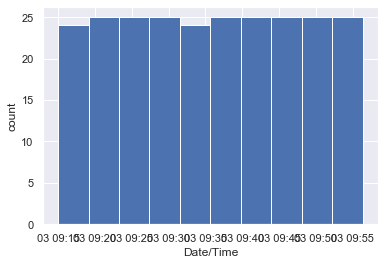

Процент пропусков: 0.0%

Детальное описание:
count                     248
unique                    248
top       2012-05-03 09:49:20
freq                        1
first     2012-05-03 09:15:00
last      2012-05-03 09:56:20
Name: Date/Time, dtype: object

Значения признака:
2012-05-03 09:49:20    0.004032
2012-05-03 09:21:00    0.004032
2012-05-03 09:23:10    0.004032
2012-05-03 09:23:00    0.004032
2012-05-03 09:22:50    0.004032
                         ...   
2012-05-03 09:34:50    0.004032
2012-05-03 09:34:40    0.004032
2012-05-03 09:34:30    0.004032
2012-05-03 09:34:20    0.004032
2012-05-03 09:49:30    0.004032
Name: Date/Time, Length: 248, dtype: float64
Столбец StuckPipe
Распределение признака:


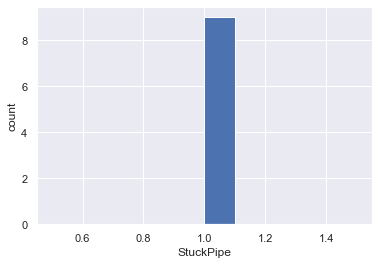

Процент пропусков: 96.37%

Детальное описание:
count    9.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: StuckPipe, dtype: float64

Значения признака:
NaN    0.96371
1.0    0.03629
Name: StuckPipe, dtype: float64
Столбец TVD
Распределение признака:


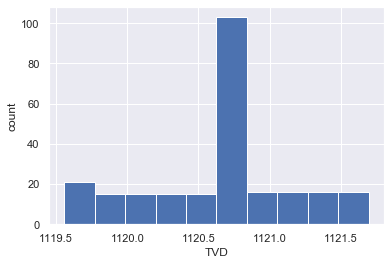

Процент пропусков: 0.0%

Детальное описание:
count     248.000000
mean     1120.673715
std         0.523418
min      1119.557900
25%      1120.364875
50%      1120.795300
75%      1120.868525
max      1121.694500
Name: TVD, dtype: float64

Значения признака:
1120.8014    0.193548
1120.7953    0.157258
1119.5579    0.012097
1119.6096    0.008065
1120.0516    0.004032
               ...   
1121.1398    0.004032
1121.4568    0.004032
1120.3990    0.004032
1120.1095    0.004032
1120.8533    0.004032
Name: TVD, Length: 160, dtype: float64
Столбец DEPT
Распределение признака:


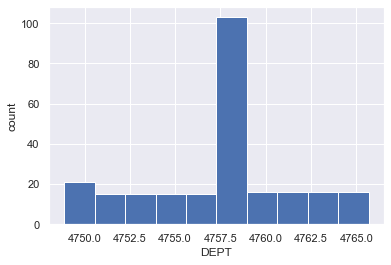

Процент пропусков: 0.0%

Детальное описание:
count     248.000000
mean     4757.660855
std         4.113694
min      4748.884800
25%      4755.237425
50%      4758.628900
75%      4759.186650
max      4765.682100
Name: DEPT, dtype: float64

Значения признака:
4758.6597    0.189516
4758.6108    0.084677
4758.6289    0.052419
4758.6167    0.020161
4749.3052    0.008065
               ...   
4753.6763    0.004032
4754.0205    0.004032
4763.4023    0.004032
4763.5117    0.004032
4759.4731    0.004032
Name: DEPT, Length: 164, dtype: float64
Столбец CDEPTH
Распределение признака:


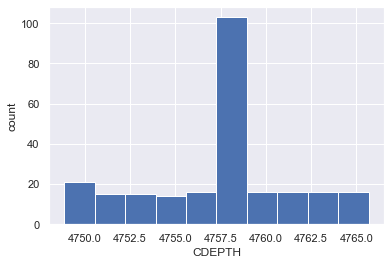

Процент пропусков: 0.0%

Детальное описание:
count     248.000000
mean     4757.632525
std         4.119183
min      4748.872600
25%      4755.237425
50%      4758.574200
75%      4759.186650
max      4765.682100
Name: CDEPTH, dtype: float64

Значения признака:
4758.5742    0.354839
4748.8726    0.024194
4761.8384    0.004032
4759.7842    0.004032
4750.0581    0.004032
               ...   
4757.3794    0.004032
4749.1191    0.004032
4748.8848    0.004032
4749.9453    0.004032
4759.4731    0.004032
Name: CDEPTH, Length: 156, dtype: float64
Столбец HDTH
Распределение признака:


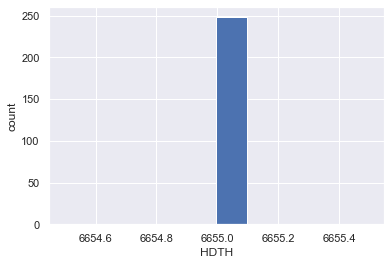

Процент пропусков: 0.0%

Детальное описание:
count    2.480000e+02
mean     6.654997e+03
std      2.187201e-11
min      6.654997e+03
25%      6.654997e+03
50%      6.654997e+03
75%      6.654997e+03
max      6.654997e+03
Name: HDTH, dtype: float64

Значения признака:
6654.9971    1.0
Name: HDTH, dtype: float64
Столбец BPOS
Распределение признака:


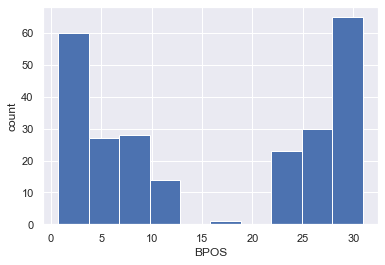

Процент пропусков: 0.0%

Детальное описание:
count    248.000000
mean      15.610802
std       11.759329
min        0.731500
25%        3.917475
50%       10.495750
75%       28.177225
max       30.934200
Name: BPOS, dtype: float64

Значения признака:
0.9388     0.084677
29.5138    0.048387
29.4833    0.032258
29.5199    0.024194
0.7315     0.024194
             ...   
3.2675     0.004032
22.4607    0.004032
26.9504    0.004032
24.6278    0.004032
1.4173     0.004032
Name: BPOS, Length: 187, dtype: float64
Столбец HKLD
Распределение признака:


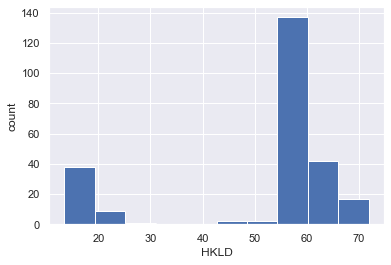

Процент пропусков: 0.0%

Детальное описание:
count    248.000000
mean      52.207294
std       16.922255
min       13.485300
25%       58.267350
50%       59.534000
75%       60.207575
max       71.917100
Name: HKLD, dtype: float64

Значения признака:
58.3637    0.012097
59.1394    0.012097
60.1010    0.012097
59.1802    0.008065
58.9489    0.008065
             ...   
57.9736    0.004032
60.5500    0.004032
20.1576    0.004032
68.2475    0.004032
59.4932    0.004032
Name: HKLD, Length: 225, dtype: float64
Столбец STOR
Распределение признака:


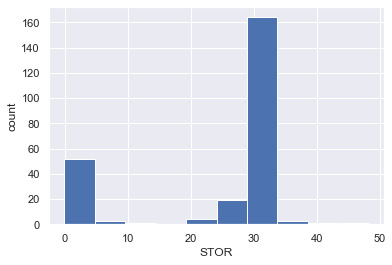

Процент пропусков: 0.0%

Детальное описание:
count    248.000000
mean      23.737258
std       12.377494
min       -0.030000
25%       26.360000
50%       30.240000
75%       30.677500
max       48.290000
Name: STOR, dtype: float64

Значения признака:
-0.02     0.056452
-0.01     0.028226
 30.20    0.016129
 30.95    0.016129
 30.48    0.016129
            ...   
 1.44     0.004032
 27.70    0.004032
 30.17    0.004032
 23.85    0.004032
 31.00    0.004032
Name: STOR, Length: 168, dtype: float64
Столбец FLWI
Распределение признака:


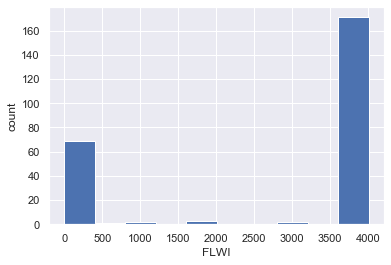

Процент пропусков: 0.0%

Детальное описание:
count     248.000000
mean     2814.702467
std      1799.520560
min         0.000000
25%         0.000000
50%      4002.089000
75%      4004.625200
max      4014.845700
Name: FLWI, dtype: float64

Значения признака:
0.0000       0.274194
4002.3918    0.032258
4003.3381    0.028226
4005.2310    0.020161
4006.2151    0.016129
               ...   
3617.2639    0.004032
4003.1868    0.004032
4007.0857    0.004032
4002.0132    0.004032
4004.8145    0.004032
Name: FLWI, Length: 131, dtype: float64
Столбец RPM
Распределение признака:


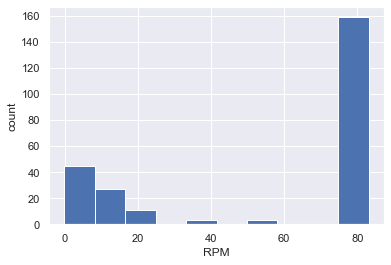

Процент пропусков: 0.0%

Детальное описание:
count    248.000000
mean      56.441048
std       35.655187
min       -0.030000
25%       11.720000
50%       81.560000
75%       83.090000
max       83.110000
Name: RPM, dtype: float64

Значения признака:
 81.56    0.233871
 83.10    0.217742
-0.03     0.060484
 83.09    0.052419
 81.55    0.048387
 11.71    0.040323
-0.02     0.032258
 23.51    0.032258
 83.08    0.028226
-0.01     0.024194
 83.11    0.024194
 83.07    0.020161
 9.79     0.016129
 23.50    0.012097
 11.72    0.012097
 14.45    0.012097
 14.46    0.008065
 0.00     0.008065
 83.06    0.008065
 14.47    0.004032
 0.09     0.004032
 11.73    0.004032
 6.36     0.004032
 1.07     0.004032
 2.67     0.004032
 55.54    0.004032
 14.48    0.004032
 0.64     0.004032
 1.51     0.004032
 0.55     0.004032
 10.24    0.004032
 38.18    0.004032
 39.89    0.004032
 83.05    0.004032
 3.17     0.004032
 1.70     0.004032
 1.80     0.004032
 4.83     0.004032
 56.61    0.004032
 82.83  

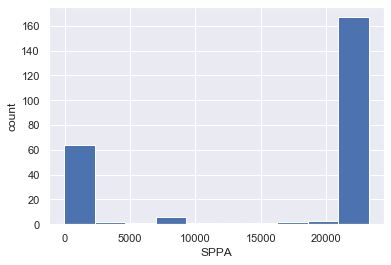

Процент пропусков: 0.0%

Детальное описание:
count      248.000000
mean     15676.570752
std       9521.767863
min        -17.788500
25%        923.587200
50%      21915.917000
75%      22015.459975
max      23251.328100
Name: SPPA, dtype: float64

Значения признака:
22035.6445    0.008065
21932.8438    0.008065
21933.7402    0.008065
21934.0156    0.008065
21943.8066    0.008065
                ...   
21892.0273    0.004032
22034.8164    0.004032
22057.2930    0.004032
21584.7266    0.004032
142.6525      0.004032
Name: SPPA, Length: 239, dtype: float64
Столбец ECD
Распределение признака:


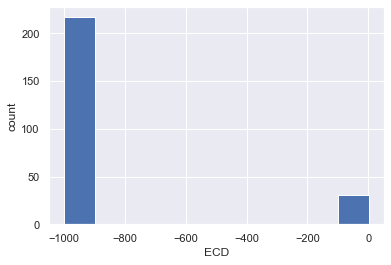

Процент пропусков: 0.0%

Детальное описание:
count    248.000000
mean    -874.166189
std      331.609901
min     -999.250000
25%     -999.250000
50%     -999.250000
75%     -999.250000
max        1.427100
Name: ECD, dtype: float64

Значения признака:
-999.2500    0.875000
 1.4247      0.024194
 1.4259      0.020161
 1.4187      0.020161
 1.4199      0.016129
 1.4175      0.012097
 1.4211      0.008065
 1.4271      0.008065
 1.4140      0.004032
 1.3900      0.004032
 1.4235      0.004032
 1.4080      0.004032
Name: ECD, dtype: float64
Столбец DLS
Распределение признака:


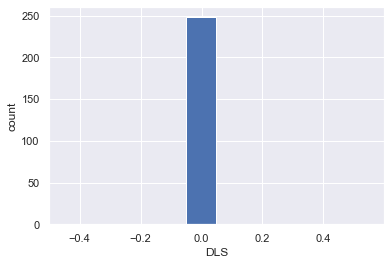

Процент пропусков: 0.0%

Детальное описание:
count    2.480000e+02
mean     4.920000e-02
std      2.224936e-16
min      4.920000e-02
25%      4.920000e-02
50%      4.920000e-02
75%      4.920000e-02
max      4.920000e-02
Name: DLS, dtype: float64

Значения признака:
0.0492    1.0
Name: DLS, dtype: float64
Столбец INCL
Распределение признака:


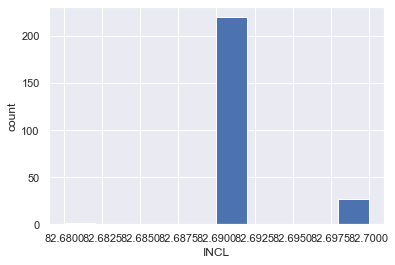

Процент пропусков: 0.0%

Детальное описание:
count    248.000000
mean      82.691048
std        0.003199
min       82.680000
25%       82.690000
50%       82.690000
75%       82.690000
max       82.700000
Name: INCL, dtype: float64

Значения признака:
82.69    0.887097
82.70    0.108871
82.68    0.004032
Name: INCL, dtype: float64
Столбец AZIM
Распределение признака:


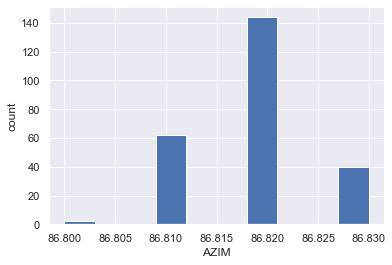

Процент пропусков: 0.0%

Детальное описание:
count    248.000000
mean      86.818952
std        0.006590
min       86.800000
25%       86.810000
50%       86.820000
75%       86.820000
max       86.830000
Name: AZIM, dtype: float64

Значения признака:
86.82    0.580645
86.81    0.250000
86.83    0.161290
86.80    0.008065
Name: AZIM, dtype: float64
Столбец GR
Распределение признака:


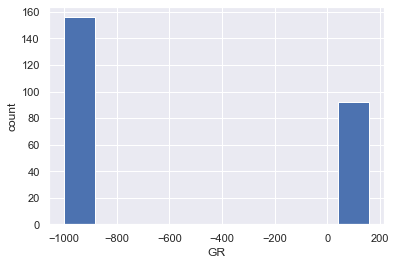

Процент пропусков: 0.0%

Детальное описание:
count    248.000000
mean    -579.516089
std      547.721523
min     -999.250000
25%     -999.250000
50%     -999.250000
75%      127.420000
max      158.400000
Name: GR, dtype: float64

Значения признака:
-999.25    0.629032
 127.42    0.060484
 136.36    0.044355
 130.37    0.040323
 133.35    0.036290
 142.49    0.032258
 115.98    0.028226
 145.60    0.024194
 139.41    0.020161
 151.93    0.020161
 105.07    0.012097
 124.51    0.008065
 121.63    0.008065
 148.75    0.008065
 107.74    0.008065
 158.40    0.004032
 113.20    0.004032
 118.79    0.004032
 99.81     0.004032
 155.15    0.004032
Name: GR, dtype: float64
Столбец APRS
Распределение признака:


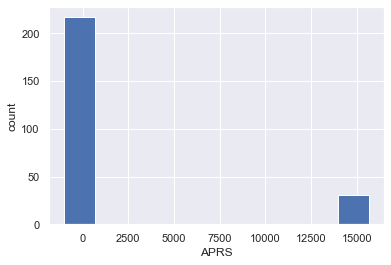

Процент пропусков: 0.0%

Детальное описание:
count      248.000000
mean      1070.811850
std       5488.016905
min       -999.250000
25%       -999.250000
50%       -999.250000
75%       -999.250000
max      15644.204100
Name: APRS, dtype: float64

Значения признака:
-999.2500      0.875000
 15623.5205    0.012097
 15609.7305    0.012097
 15547.6777    0.012097
 15540.7832    0.012097
 15533.8877    0.008065
 15526.9932    0.008065
 15637.3096    0.008065
 15630.4150    0.008065
 15616.6250    0.008065
 15485.6250    0.004032
 15554.5723    0.004032
 15602.8359    0.004032
 15513.2041    0.004032
 15430.4668    0.004032
 15644.2041    0.004032
 15520.0986    0.004032
 15561.4668    0.004032
 15230.5186    0.004032
Name: APRS, dtype: float64
Столбец BVEL
Распределение признака:


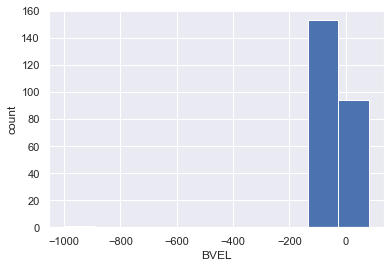

Процент пропусков: 0.0%

Детальное описание:
count    248.000000
mean     -27.651544
std       65.357227
min     -999.250000
25%      -39.540700
50%      -36.701000
75%        0.000000
max       82.296000
Name: BVEL, dtype: float64

Значения признака:
 0.0000      0.338710
-36.2188     0.068548
-39.5407     0.064516
-38.3619     0.052419
-40.6122     0.048387
-37.2904     0.044355
-41.6838     0.040323
-38.4691     0.036290
-42.8625     0.024194
-37.1832     0.020161
-35.1472     0.016129
-37.3975     0.016129
-45.0056     0.016129
-39.4335     0.016129
-38.2548     0.016129
-42.9697     0.012097
-42.7553     0.012097
-42.6482     0.012097
-41.8981     0.012097
-32.8970     0.008065
-43.9341     0.008065
-34.0757     0.008065
-36.1117     0.008065
-39.3263     0.008065
-37.5047     0.004032
 6.6437      0.004032
-17.5736     0.004032
 1.1787      0.004032
 60.3290     0.004032
 82.2960     0.004032
-43.7197     0.004032
-41.5766     0.004032
-38.0878     0.004032
-38.5763     0.004032


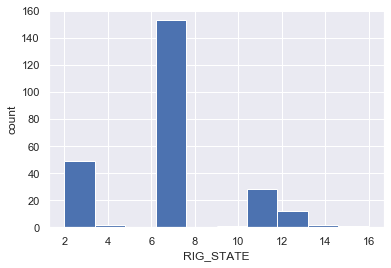

Процент пропусков: 0.0%

Детальное описание:
count    248.000000
mean       6.794355
std        2.950682
min        2.000000
25%        7.000000
50%        7.000000
75%        7.000000
max       16.000000
Name: RIG_STATE, dtype: float64

Значения признака:
7     0.616935
2     0.189516
11    0.112903
12    0.048387
14    0.008065
4     0.008065
3     0.008065
16    0.004032
10    0.004032
Name: RIG_STATE, dtype: float64
Столбец Stick_Slip_Ratio
Распределение признака:


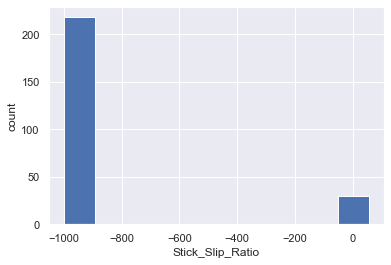

Процент пропусков: 0.0%

Детальное описание:
count    248.000000
mean    -876.857932
std      330.619984
min     -999.250000
25%     -999.250000
50%     -999.250000
75%     -999.250000
max       55.990400
Name: Stick_Slip_Ratio, dtype: float64

Значения признака:
-999.2500    0.879032
 7.3565      0.016129
 9.0253      0.012097
 9.1957      0.012097
 5.5181      0.008065
 7.2202      0.008065
 5.4158      0.008065
 12.6354     0.008065
 11.0348     0.008065
 12.8740     0.004032
 43.3161     0.004032
 7.2220      0.004032
 5.4152      0.004032
 7.3574      0.004032
 32.4910     0.004032
 19.8580     0.004032
 12.6369     0.004032
 55.9904     0.004032
 10.8342     0.004032
Name: Stick_Slip_Ratio, dtype: float64
Столбец StickPercentage
Распределение признака:


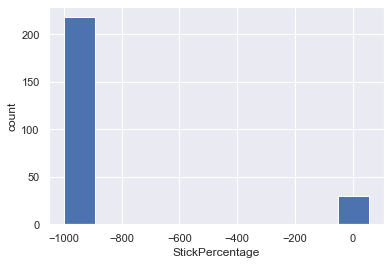

Процент пропусков: 0.0%

Детальное описание:
count    248.000000
mean    -876.857932
std      330.619984
min     -999.250000
25%     -999.250000
50%     -999.250000
75%     -999.250000
max       55.990400
Name: StickPercentage, dtype: float64

Значения признака:
-999.2500    0.879032
 7.3565      0.016129
 9.0253      0.012097
 9.1957      0.012097
 5.5181      0.008065
 7.2202      0.008065
 5.4158      0.008065
 12.6354     0.008065
 11.0348     0.008065
 12.8740     0.004032
 43.3161     0.004032
 7.2220      0.004032
 5.4152      0.004032
 7.3574      0.004032
 32.4910     0.004032
 19.8580     0.004032
 12.6369     0.004032
 55.9904     0.004032
 10.8342     0.004032
Name: StickPercentage, dtype: float64
Столбец ESD
Распределение признака:


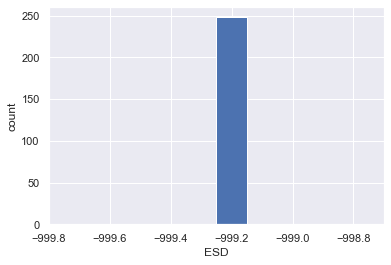

Процент пропусков: 0.0%

Детальное описание:
count    248.00
mean    -999.25
std        0.00
min     -999.25
25%     -999.25
50%     -999.25
75%     -999.25
max     -999.25
Name: ESD, dtype: float64

Значения признака:
-999.25    1.0
Name: ESD, dtype: float64


In [242]:
for col in df1.columns:
    desription(df1, col)

Столбец Date/Time
Распределение признака:


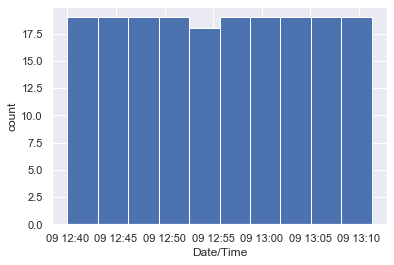

Процент пропусков: 0.0%

Детальное описание:
count                     189
unique                    189
top       2015-05-09 13:11:20
freq                        1
first     2015-05-09 12:40:00
last      2015-05-09 13:11:20
Name: Date/Time, dtype: object

Значения признака:
2015-05-09 13:11:20    0.005291
2015-05-09 12:49:40    0.005291
2015-05-09 12:51:10    0.005291
2015-05-09 12:51:00    0.005291
2015-05-09 12:50:50    0.005291
                         ...   
2015-05-09 13:00:30    0.005291
2015-05-09 13:00:20    0.005291
2015-05-09 13:00:10    0.005291
2015-05-09 13:00:00    0.005291
2015-05-09 12:40:00    0.005291
Name: Date/Time, Length: 189, dtype: float64
Столбец StuckPipe
Распределение признака:


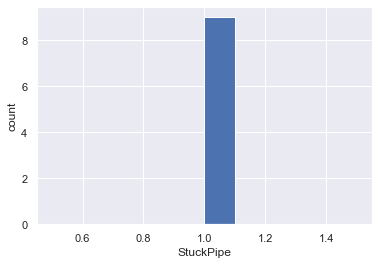

Процент пропусков: 95.24%

Детальное описание:
count    9.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: StuckPipe, dtype: float64

Значения признака:
NaN    0.952381
1.0    0.047619
Name: StuckPipe, dtype: float64
Столбец TVD
Распределение признака:


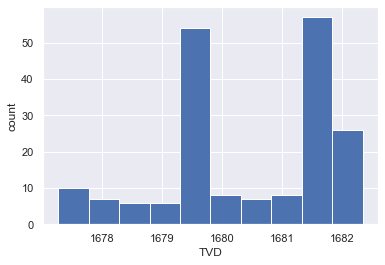

Процент пропусков: 0.0%

Детальное описание:
count     189.000000
mean     1680.399561
std         1.375800
min      1677.271700
25%      1679.493800
50%      1680.581900
75%      1681.459700
max      1682.346700
Name: TVD, dtype: float64

Значения признака:
1679.4938    0.169312
1681.4597    0.153439
1679.4998    0.068783
1681.4567    0.068783
1681.4628    0.015873
               ...   
1679.6095    0.005291
1680.9751    0.005291
1680.1704    0.005291
1677.3296    0.005291
1679.6797    0.005291
Name: TVD, Length: 99, dtype: float64
Столбец DEPT
Распределение признака:


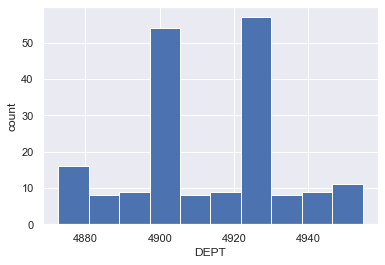

Процент пропусков: 0.0%

Детальное описание:
count     189.000000
mean     4912.431853
std        20.730931
min      4872.706500
25%      4898.995600
50%      4912.711400
75%      4926.881800
max      4954.579100
Name: DEPT, dtype: float64

Значения признака:
4926.8818    0.164021
4898.9956    0.153439
4926.7935    0.063492
4899.0566    0.058201
4898.9346    0.010582
               ...   
4887.4741    0.005291
4922.7852    0.005291
4896.4717    0.005291
4872.8496    0.005291
4881.8081    0.005291
Name: DEPT, Length: 108, dtype: float64
Столбец CDEPTH
Распределение признака:


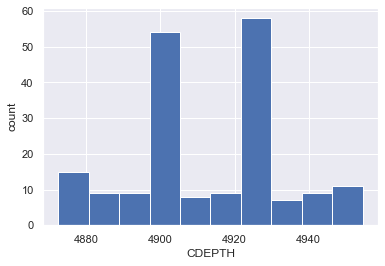

Процент пропусков: 0.0%

Детальное описание:
count     189.000000
mean     4912.199282
std        20.842294
min      4872.483900
25%      4898.873500
50%      4912.757300
75%      4926.622600
max      4954.557600
Name: CDEPTH, dtype: float64

Значения признака:
4926.6226    0.248677
4898.8735    0.243386
4872.4839    0.042328
4910.7852    0.005291
4873.8892    0.005291
               ...   
4941.2925    0.005291
4887.4741    0.005291
4922.7852    0.005291
4896.4717    0.005291
4923.6724    0.005291
Name: CDEPTH, Length: 91, dtype: float64
Столбец HDTH
Распределение признака:


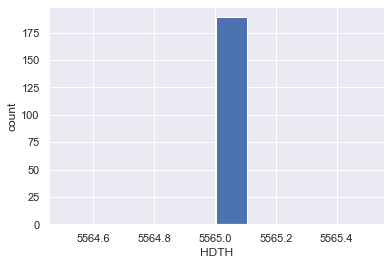

Процент пропусков: 0.0%

Детальное описание:
count    1.890000e+02
mean     5.565005e+03
std      2.826922e-11
min      5.565005e+03
25%      5.565005e+03
50%      5.565005e+03
75%      5.565005e+03
max      5.565005e+03
Name: HDTH, dtype: float64

Значения признака:
5565.0049    1.0
Name: HDTH, dtype: float64
Столбец BPOS
Распределение признака:


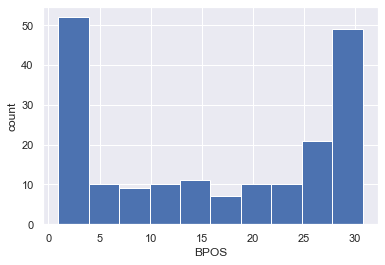

Процент пропусков: 0.0%

Детальное описание:
count    189.000000
mean      15.990149
std       11.379705
min        0.966200
25%        3.078500
50%       16.544500
75%       28.367700
max       30.754300
Name: BPOS, dtype: float64

Значения признака:
1.2253     0.063492
1.3686     0.058201
29.1663    0.037037
29.1846    0.037037
29.2273    0.026455
             ...   
1.1826     0.005291
12.7894    0.005291
15.7886    0.005291
6.4587     0.005291
1.7861     0.005291
Name: BPOS, Length: 138, dtype: float64
Столбец HKLD
Распределение признака:


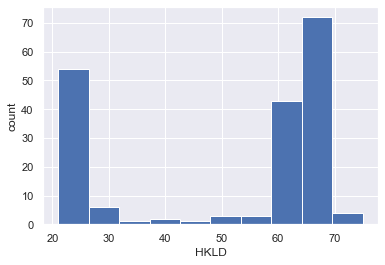

Процент пропусков: 0.0%

Детальное описание:
count    189.000000
mean      51.154467
std       18.185888
min       21.046700
25%       25.859300
50%       63.366900
75%       64.931700
max       74.956100
Name: HKLD, dtype: float64

Значения признака:
65.0451    0.015873
25.8185    0.015873
64.8138    0.010582
25.2832    0.010582
65.3218    0.010582
             ...   
24.6800    0.005291
64.6006    0.005291
60.4865    0.005291
25.0247    0.005291
60.4049    0.005291
Name: HKLD, Length: 176, dtype: float64
Столбец STOR
Распределение признака:


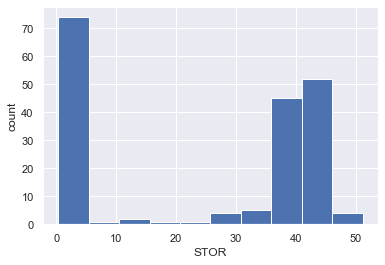

Процент пропусков: 0.0%

Детальное описание:
count    189.000000
mean      24.429114
std       19.524445
min        0.352500
25%        0.718600
50%       38.790000
75%       41.338900
max       51.168600
Name: STOR, dtype: float64

Значения признака:
0.3661     0.052910
0.3932     0.042328
2.7523     0.031746
0.3525     0.021164
0.3796     0.015873
             ...   
0.6779     0.005291
0.8677     0.005291
40.3220    0.005291
41.9083    0.005291
15.9037    0.005291
Name: STOR, Length: 143, dtype: float64
Столбец FLWI
Распределение признака:


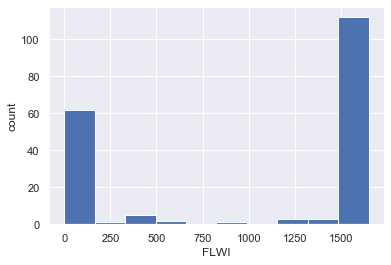

Процент пропусков: 0.0%

Детальное описание:
count     189.000000
mean     1027.487807
std       761.667004
min         0.000000
25%         0.000000
50%      1624.661000
75%      1625.910200
max      1651.196700
Name: FLWI, dtype: float64

Значения признака:
0.0000       0.328042
1624.6610    0.243386
1628.8628    0.105820
1620.4971    0.021164
1625.9102    0.010582
               ...   
1623.7146    0.005291
1627.0079    0.005291
1626.8186    0.005291
1612.2070    0.005291
1628.5978    0.005291
Name: FLWI, Length: 58, dtype: float64
Столбец RPM
Распределение признака:


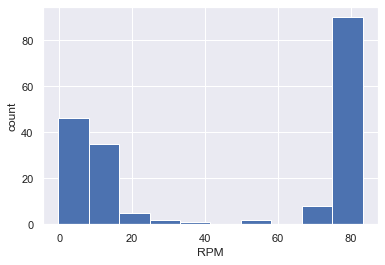

Процент пропусков: 0.0%

Детальное описание:
count    189.000000
mean      46.048307
std       37.289872
min       -0.320000
25%       12.580000
50%       72.300000
75%       81.720000
max       83.330000
Name: RPM, dtype: float64

Значения признака:
-0.32     0.190476
 12.62    0.047619
 12.63    0.037037
 12.61    0.031746
 12.64    0.026455
            ...   
 81.78    0.005291
 73.95    0.005291
 82.97    0.005291
 83.05    0.005291
 81.75    0.005291
Name: RPM, Length: 109, dtype: float64
Столбец SPPA
Распределение признака:


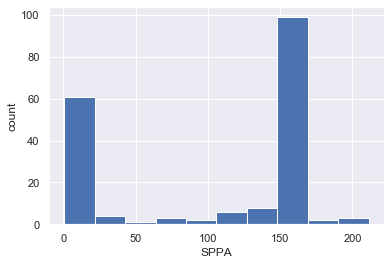

Процент пропусков: 0.0%

Детальное описание:
count    189.000000
mean     104.040077
std       69.832790
min        0.659400
25%       11.388200
50%      156.306400
75%      158.866200
max      211.199000
Name: SPPA, dtype: float64

Значения признака:
11.8094     0.005291
74.2674     0.005291
157.7625    0.005291
158.4348    0.005291
158.0694    0.005291
              ...   
158.8662    0.005291
168.6438    0.005291
157.0991    0.005291
155.3401    0.005291
157.9728    0.005291
Name: SPPA, Length: 189, dtype: float64
Столбец ECD
Распределение признака:


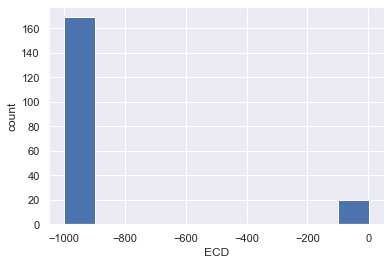

Процент пропусков: 0.0%

Детальное описание:
count    189.000000
mean    -893.348332
std      308.661977
min     -999.250000
25%     -999.250000
50%     -999.250000
75%     -999.250000
max        1.701500
Name: ECD, dtype: float64

Значения признака:
-999.2500    0.894180
 1.5098      0.031746
 1.5122      0.015873
 1.5110      0.015873
 1.5410      0.005291
 1.5038      0.005291
 1.5062      0.005291
 1.5074      0.005291
 1.7015      0.005291
 1.5086      0.005291
 1.5134      0.005291
 1.5050      0.005291
Name: ECD, dtype: float64
Столбец DLS
Распределение признака:


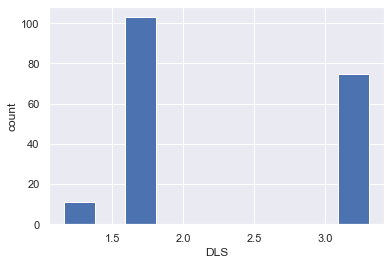

Процент пропусков: 0.0%

Детальное описание:
count    189.000000
mean       2.340070
std        0.798472
min        1.161400
25%        1.761800
50%        1.761800
75%        3.307100
max        3.307100
Name: DLS, dtype: float64

Значения признака:
1.7618    0.544974
3.3071    0.396825
1.1614    0.058201
Name: DLS, dtype: float64
Столбец INCL
Распределение признака:


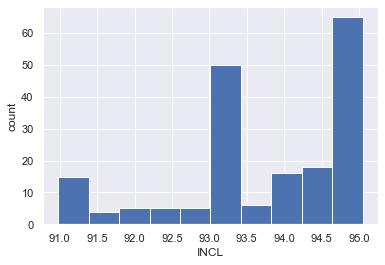

Процент пропусков: 0.0%

Детальное описание:
count    189.000000
mean      93.670635
std        1.164251
min       90.980000
25%       93.140000
50%       93.960000
75%       94.760000
max       95.050000
Name: INCL, dtype: float64

Значения признака:
93.14    0.222222
94.77    0.174603
94.76    0.079365
91.02    0.021164
93.13    0.021164
           ...   
92.90    0.005291
94.45    0.005291
94.55    0.005291
91.08    0.005291
94.50    0.005291
Name: INCL, Length: 87, dtype: float64
Столбец AZIM
Распределение признака:


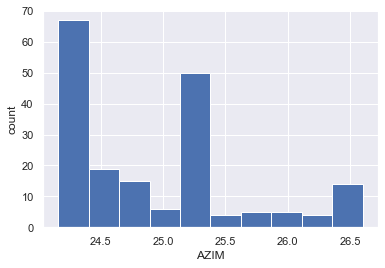

Процент пропусков: 0.0%

Детальное описание:
count    189.000000
mean      24.942804
std        0.683289
min       24.160000
25%       24.320000
50%       24.750000
75%       25.230000
max       26.600000
Name: AZIM, dtype: float64

Значения признака:
25.23    0.222222
24.31    0.169312
24.32    0.084656
25.24    0.021164
26.60    0.015873
           ...   
26.51    0.005291
25.93    0.005291
24.60    0.005291
24.22    0.005291
24.75    0.005291
Name: AZIM, Length: 81, dtype: float64
Столбец GR
Распределение признака:


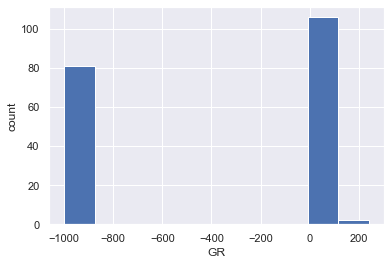

Процент пропусков: 0.0%

Детальное описание:
count    189.000000
mean    -384.026931
std      534.422930
min     -999.250000
25%     -999.250000
50%       68.930000
75%       76.840000
max      240.060000
Name: GR, dtype: float64

Значения признака:
-999.25    0.428571
 76.30     0.015873
 72.96     0.010582
 73.90     0.010582
 78.70     0.010582
             ...   
 89.69     0.005291
 73.05     0.005291
 39.85     0.005291
 68.80     0.005291
 77.50     0.005291
Name: GR, Length: 100, dtype: float64
Столбец APRS
Распределение признака:


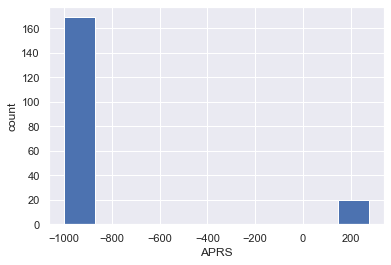

Процент пропусков: 0.0%

Детальное описание:
count    189.000000
mean    -867.369888
std      384.385536
min     -999.250000
25%     -999.250000
50%     -999.250000
75%     -999.250000
max      276.538800
Name: APRS, dtype: float64

Значения признака:
-999.2500    0.894180
 245.3057    0.021164
 245.1696    0.010582
 245.1016    0.010582
 245.5098    0.010582
 244.8294    0.005291
 245.0335    0.005291
 244.8974    0.005291
 245.2377    0.005291
 245.7140    0.005291
 250.5452    0.005291
 244.4892    0.005291
 245.5779    0.005291
 244.6933    0.005291
 276.5388    0.005291
Name: APRS, dtype: float64
Столбец BVEL
Распределение признака:


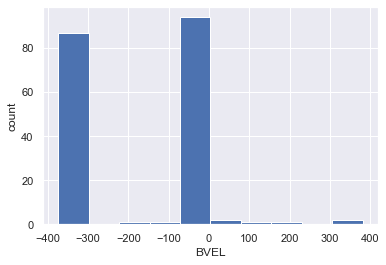

Процент пропусков: 0.0%

Детальное описание:
count    189.000000
mean    -151.749760
std      180.467659
min     -373.730500
25%     -337.343500
50%        0.000000
75%        0.000000
max      380.945100
Name: BVEL, dtype: float64

Значения признака:
 0.0000      0.481481
-337.1240    0.005291
-337.9104    0.005291
-342.7628    0.005291
-322.0395    0.005291
               ...   
-319.1774    0.005291
-341.2419    0.005291
-320.9849    0.005291
-357.4298    0.005291
-337.3435    0.005291
Name: BVEL, Length: 99, dtype: float64
Столбец RIG_STATE
Распределение признака:


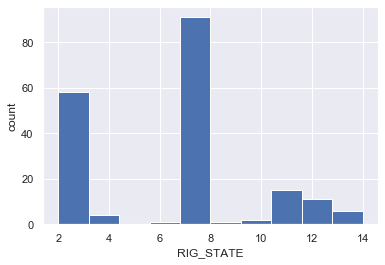

Процент пропусков: 0.0%

Детальное описание:
count    189.000000
mean       6.280423
std        3.413161
min        2.000000
25%        2.000000
50%        7.000000
75%        7.000000
max       14.000000
Name: RIG_STATE, dtype: float64

Значения признака:
7     0.481481
2     0.291005
11    0.079365
12    0.058201
14    0.031746
4     0.021164
3     0.015873
10    0.010582
8     0.005291
6     0.005291
Name: RIG_STATE, dtype: float64
Столбец Stick_Slip_Ratio
Распределение признака:


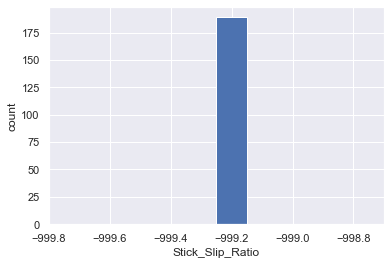

Процент пропусков: 0.0%

Детальное описание:
count    189.00
mean    -999.25
std        0.00
min     -999.25
25%     -999.25
50%     -999.25
75%     -999.25
max     -999.25
Name: Stick_Slip_Ratio, dtype: float64

Значения признака:
-999.25    1.0
Name: Stick_Slip_Ratio, dtype: float64
Столбец StickPercentage
Распределение признака:


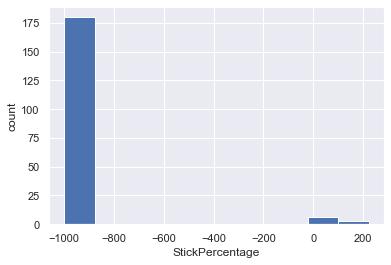

Процент пропусков: 0.0%

Детальное описание:
count    189.000000
mean    -947.047619
std      234.427515
min     -999.250000
25%     -999.250000
50%     -999.250000
75%     -999.250000
max      222.000000
Name: StickPercentage, dtype: float64

Значения признака:
-999.25    0.952381
 60.00     0.010582
 222.00    0.005291
 135.00    0.005291
 69.00     0.005291
 162.00    0.005291
 48.00     0.005291
 78.00     0.005291
 39.00     0.005291
Name: StickPercentage, dtype: float64
Столбец ESD
Распределение признака:


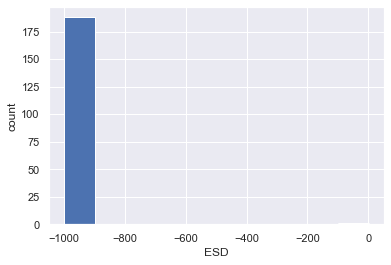

Процент пропусков: 0.0%

Детальное описание:
count    189.000000
mean    -993.955900
std       72.781842
min     -999.250000
25%     -999.250000
50%     -999.250000
75%     -999.250000
max        1.334900
Name: ESD, dtype: float64

Значения признака:
-999.2500    0.994709
 1.3349      0.005291
Name: ESD, dtype: float64


In [243]:
for col in df2.columns:
    desription(df2, col)

Столбец date/time
Распределение признака:


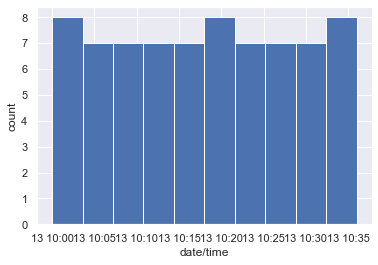

Процент пропусков: 0.0%

Детальное описание:
count                      73
unique                     72
top       2012-12-13 10:35:00
freq                        2
first     2012-12-13 10:00:00
last      2012-12-13 10:36:00
Name: date/time, dtype: object

Значения признака:
2012-12-13 10:35:00    0.027397
2012-12-13 10:07:30    0.013699
2012-12-13 10:31:00    0.013699
2012-12-13 10:13:00    0.013699
2012-12-13 10:31:30    0.013699
                         ...   
2012-12-13 10:02:00    0.013699
2012-12-13 10:20:30    0.013699
2012-12-13 10:02:30    0.013699
2012-12-13 10:21:00    0.013699
2012-12-13 10:08:00    0.013699
Name: date/time, Length: 72, dtype: float64
Столбец stuckpipe
Распределение признака:


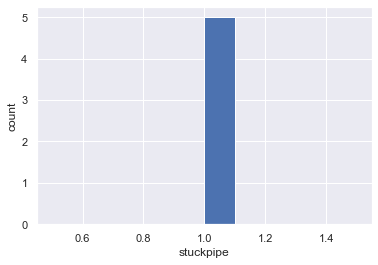

Процент пропусков: 93.15%

Детальное описание:
count    5.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: stuckpipe, dtype: float64

Значения признака:
NaN    0.931507
1.0    0.068493
Name: stuckpipe, dtype: float64
Столбец tvd
Распределение признака:


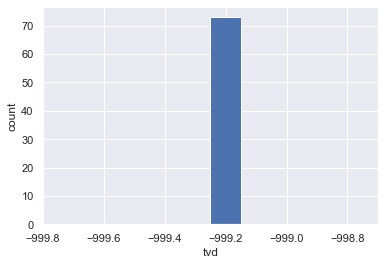

Процент пропусков: 0.0%

Детальное описание:
count     73.00
mean    -999.25
std        0.00
min     -999.25
25%     -999.25
50%     -999.25
75%     -999.25
max     -999.25
Name: tvd, dtype: float64

Значения признака:
-999.25    1.0
Name: tvd, dtype: float64
Столбец dept
Распределение признака:


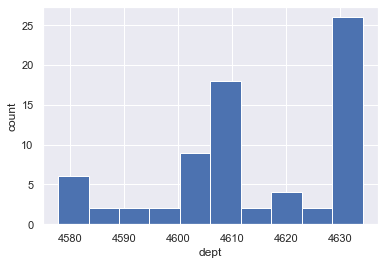

Процент пропусков: 0.0%

Детальное описание:
count      73.000000
mean     4614.242338
std        17.681589
min      4577.812500
25%      4605.958000
50%      4606.293000
75%      4633.907700
max      4634.167000
Name: dept, dtype: float64

Значения признака:
4606.2930    0.205479
4634.1670    0.191781
4633.9077    0.109589
4605.9580    0.082192
4578.2422    0.041096
4630.8843    0.013699
4619.5825    0.013699
4594.2075    0.013699
4599.7549    0.013699
4585.2832    0.013699
4606.2383    0.013699
4622.8164    0.013699
4624.4136    0.013699
4607.8628    0.013699
4610.8560    0.013699
4631.9634    0.013699
4618.6191    0.013699
4579.2236    0.013699
4621.2495    0.013699
4588.4165    0.013699
4605.8237    0.013699
4596.9907    0.013699
4613.8491    0.013699
4577.8125    0.013699
4627.2939    0.013699
4605.1807    0.013699
4602.5591    0.013699
4616.7446    0.013699
4630.0063    0.013699
4591.2358    0.013699
4582.2534    0.013699
4634.1001    0.013699
Name: dept, dtype: float64
Столбец c

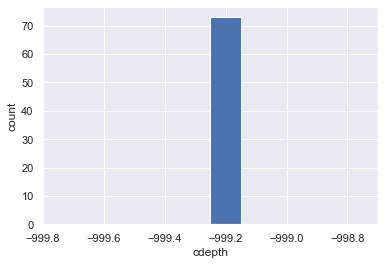

Процент пропусков: 0.0%

Детальное описание:
count     73.00
mean    -999.25
std        0.00
min     -999.25
25%     -999.25
50%     -999.25
75%     -999.25
max     -999.25
Name: cdepth, dtype: float64

Значения признака:
-999.25    1.0
Name: cdepth, dtype: float64
Столбец hdth
Распределение признака:


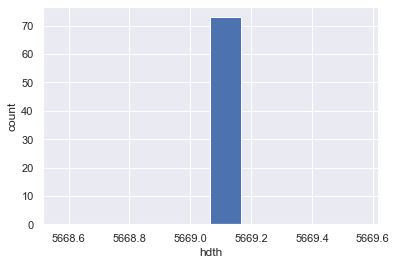

Процент пропусков: 0.0%

Детальное описание:
count    7.300000e+01
mean     5.669066e+03
std      6.410522e-12
min      5.669066e+03
25%      5.669066e+03
50%      5.669066e+03
75%      5.669066e+03
max      5.669066e+03
Name: hdth, dtype: float64

Значения признака:
5669.0664    1.0
Name: hdth, dtype: float64
Столбец bpos
Распределение признака:


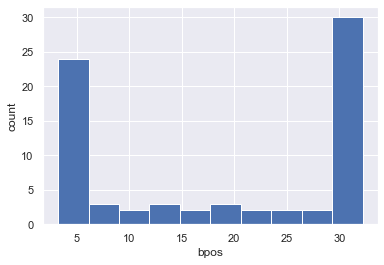

Процент пропусков: 0.0%

Детальное описание:
count    73.000000
mean     18.442989
std      12.350538
min       3.240000
25%       3.709400
50%      18.998200
75%      31.345600
max      32.202100
Name: bpos, dtype: float64

Значения признака:
3.7094     0.109589
3.7003     0.082192
31.3152    0.054795
31.4157    0.041096
31.4096    0.041096
             ...   
18.9982    0.013699
7.3518     0.013699
10.5735    0.013699
31.4797    0.013699
23.9969    0.013699
Name: bpos, Length: 51, dtype: float64
Столбец hkld
Распределение признака:


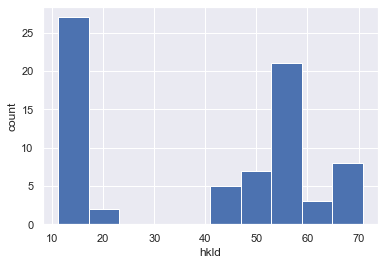

Процент пропусков: 0.0%

Детальное описание:
count    73.000000
mean     39.468508
std      21.526983
min      11.194700
25%      14.646500
50%      50.339700
75%      55.515200
max      70.783100
Name: hkld, dtype: float64

Значения признака:
55.3383    0.027397
53.9049    0.013699
17.7854    0.013699
59.4297    0.013699
14.2519    0.013699
             ...   
14.6465    0.013699
12.1744    0.013699
50.0811    0.013699
14.0840    0.013699
44.0574    0.013699
Name: hkld, Length: 72, dtype: float64
Столбец stor
Распределение признака:


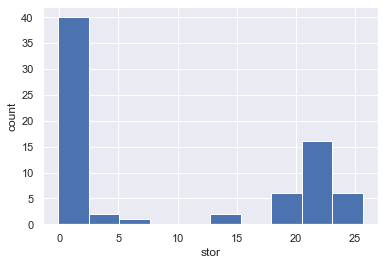

Процент пропусков: 0.0%

Детальное описание:
count    73.000000
mean      8.991370
std      10.359747
min      -0.080000
25%      -0.040000
50%       1.360000
75%      20.990000
max      25.640000
Name: stor, dtype: float64

Значения признака:
-0.06     0.136986
-0.05     0.068493
-0.01     0.068493
-0.04     0.027397
 0.00     0.027397
            ...   
 21.39    0.013699
 20.74    0.013699
-0.03     0.013699
 21.51    0.013699
 21.26    0.013699
Name: stor, Length: 54, dtype: float64
Столбец flwi
Распределение признака:


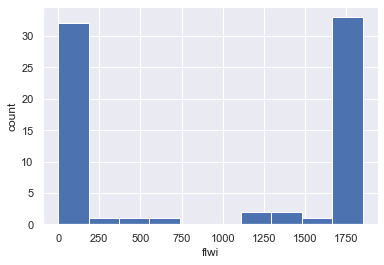

Процент пропусков: 0.0%

Детальное описание:
count      73.000000
mean      928.087611
std       872.142669
min         0.000000
25%         0.000000
50%      1292.226100
75%      1811.395400
max      1850.536500
Name: flwi, dtype: float64

Значения признака:
0.0000       0.438356
1812.0768    0.027397
1811.5089    0.027397
1800.1149    0.013699
1815.2565    0.013699
1800.3419    0.013699
1811.9253    0.013699
1801.1747    0.013699
1539.5649    0.013699
1850.5365    0.013699
1815.1808    0.013699
1787.2822    0.013699
1768.4688    0.013699
466.0978     0.013699
1813.8558    0.013699
1787.7744    0.013699
1811.3954    0.013699
1297.4878    0.013699
1814.0452    0.013699
1153.9071    0.013699
1795.5344    0.013699
617.7414     0.013699
1800.4176    0.013699
1813.5909    0.013699
1477.7113    0.013699
283.9059     0.013699
1812.6824    0.013699
1292.2261    0.013699
1812.4932    0.013699
1796.1401    0.013699
1789.1371    0.013699
1813.4395    0.013699
1811.6603    0.013699
1811.1304    0

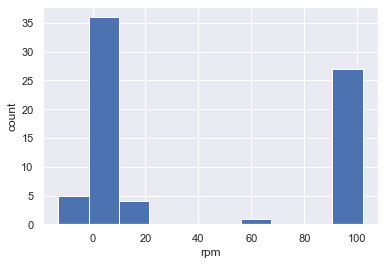

Процент пропусков: 0.0%

Детальное описание:
count     73.000000
mean      38.552329
std       48.952465
min      -12.980000
25%        0.290000
50%        0.370000
75%      100.170000
max      102.040000
Name: rpm, dtype: float64

Значения признака:
 0.30      0.068493
 0.33      0.054795
 0.28      0.054795
 0.32      0.054795
 0.29      0.041096
             ...   
-1.07      0.013699
 0.13      0.013699
 100.21    0.013699
 100.20    0.013699
-1.12      0.013699
Name: rpm, Length: 54, dtype: float64
Столбец sppa
Распределение признака:


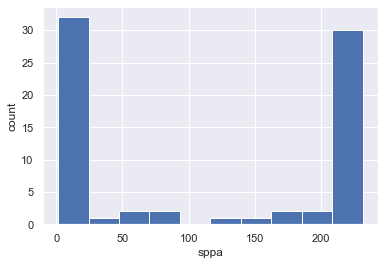

Процент пропусков: 0.0%

Детальное описание:
count     73.000000
mean     115.243214
std      104.343491
min        1.427900
25%        4.108600
50%       85.845200
75%      227.177400
max      231.509400
Name: sppa, dtype: float64

Значения признака:
1.9112      0.013699
23.4966     0.013699
9.9167      0.013699
227.0885    0.013699
228.7191    0.013699
              ...   
4.1086      0.013699
227.8331    0.013699
21.4310     0.013699
3.7880      0.013699
15.5608     0.013699
Name: sppa, Length: 73, dtype: float64
Столбец ecd
Распределение признака:


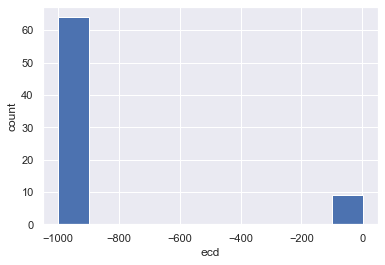

Процент пропусков: 0.0%

Детальное описание:
count     73.000000
mean    -875.864959
std      331.303805
min     -999.250000
25%     -999.250000
50%     -999.250000
75%     -999.250000
max        1.580500
Name: ecd, dtype: float64

Значения признака:
-999.2500    0.876712
 1.5254      0.027397
 1.5338      0.013699
 1.5565      0.013699
 1.5374      0.013699
 1.5805      0.013699
 1.5266      0.013699
 1.5494      0.013699
 1.5230      0.013699
Name: ecd, dtype: float64
Столбец dls
Распределение признака:


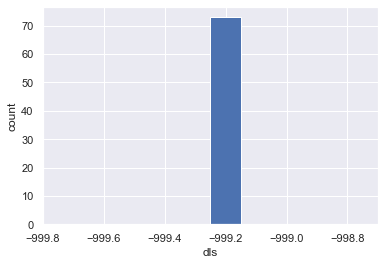

Процент пропусков: 0.0%

Детальное описание:
count     73.00
mean    -999.25
std        0.00
min     -999.25
25%     -999.25
50%     -999.25
75%     -999.25
max     -999.25
Name: dls, dtype: float64

Значения признака:
-999.25    1.0
Name: dls, dtype: float64
Столбец incl
Распределение признака:


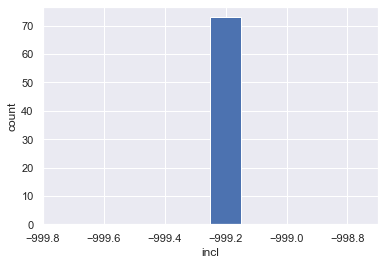

Процент пропусков: 0.0%

Детальное описание:
count     73.00
mean    -999.25
std        0.00
min     -999.25
25%     -999.25
50%     -999.25
75%     -999.25
max     -999.25
Name: incl, dtype: float64

Значения признака:
-999.25    1.0
Name: incl, dtype: float64
Столбец azim
Распределение признака:


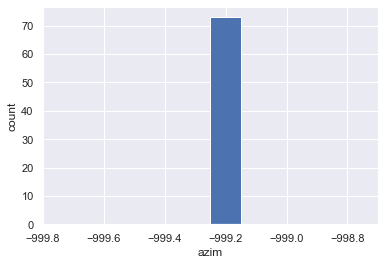

Процент пропусков: 0.0%

Детальное описание:
count     73.00
mean    -999.25
std        0.00
min     -999.25
25%     -999.25
50%     -999.25
75%     -999.25
max     -999.25
Name: azim, dtype: float64

Значения признака:
-999.25    1.0
Name: azim, dtype: float64
Столбец gr
Распределение признака:


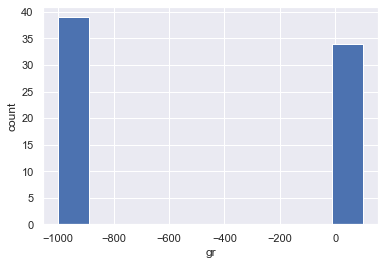

Процент пропусков: 0.0%

Детальное описание:
count     73.000000
mean    -494.590137
std      544.312661
min     -999.250000
25%     -999.250000
50%     -999.250000
75%       87.150000
max       99.150000
Name: gr, dtype: float64

Значения признака:
-999.25    0.534247
 89.30     0.027397
 88.47     0.013699
 86.43     0.013699
 88.45     0.013699
 60.16     0.013699
 84.74     0.013699
 89.53     0.013699
 89.99     0.013699
 88.82     0.013699
 87.01     0.013699
 91.66     0.013699
 85.63     0.013699
 83.83     0.013699
 85.21     0.013699
 83.29     0.013699
 87.08     0.013699
 87.74     0.013699
 91.73     0.013699
 93.26     0.013699
 87.44     0.013699
 90.49     0.013699
 63.43     0.013699
 91.89     0.013699
 38.37     0.013699
 87.15     0.013699
 93.08     0.013699
 86.73     0.013699
 93.64     0.013699
 86.01     0.013699
 86.08     0.013699
 99.15     0.013699
 90.82     0.013699
 39.76     0.013699
Name: gr, dtype: float64
Столбец aprs
Распределение признака:


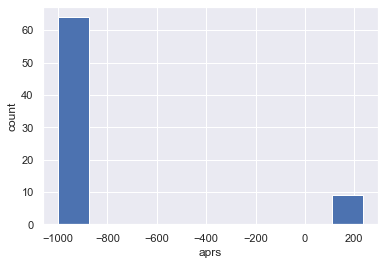

Процент пропусков: 0.0%

Детальное описание:
count     73.000000
mean    -847.995021
std      406.139077
min     -999.250000
25%     -999.250000
50%     -999.250000
75%     -999.250000
max      233.594400
Name: aprs, dtype: float64

Значения признака:
-999.2500    0.876712
 230.0780    0.013699
 229.1128    0.013699
 225.6654    0.013699
 226.7686    0.013699
 225.0449    0.013699
 233.5944    0.013699
 227.1823    0.013699
 225.5275    0.013699
 225.3896    0.013699
Name: aprs, dtype: float64
Столбец bvel
Распределение признака:


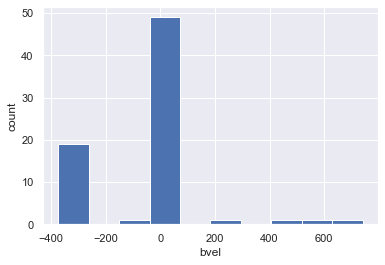

Процент пропусков: 0.0%

Детальное описание:
count     73.000000
mean     -64.848914
std      208.456734
min     -372.807000
25%     -324.636400
50%        0.000000
75%        0.000000
max      740.810300
Name: bvel, dtype: float64

Значения признака:
 0.0000      0.671233
-145.4902    0.013699
-358.8319    0.013699
-325.9531    0.013699
-345.8779    0.013699
-326.9376    0.013699
-362.7303    0.013699
-343.8906    0.013699
-326.2884    0.013699
 740.8103    0.013699
 223.2812    0.013699
-341.6808    0.013699
 444.9501    0.013699
-359.8194    0.013699
-328.7817    0.013699
-362.7151    0.013699
-344.5977    0.013699
-340.6963    0.013699
-325.8586    0.013699
 579.8333    0.013699
-324.6364    0.013699
-358.6368    0.013699
-364.5439    0.013699
-372.8070    0.013699
-362.0719    0.013699
Name: bvel, dtype: float64
Столбец rig_state
Распределение признака:


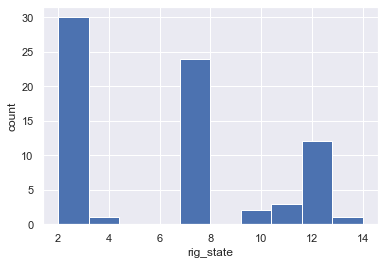

Процент пропусков: 0.0%

Детальное описание:
count    73.000000
mean      6.082192
std       3.914905
min       2.000000
25%       2.000000
50%       7.000000
75%       7.000000
max      14.000000
Name: rig_state, dtype: float64

Значения признака:
2     0.397260
7     0.328767
12    0.164384
11    0.041096
10    0.027397
14    0.013699
4     0.013699
3     0.013699
Name: rig_state, dtype: float64
Столбец stick_slip_ratio
Распределение признака:


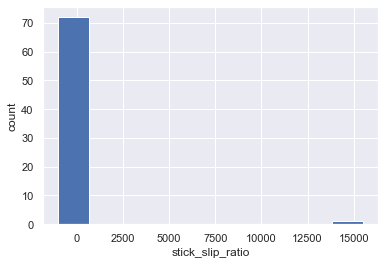

Процент пропусков: 0.0%

Детальное описание:
count       73.000000
mean      -670.815956
std       1943.121189
min       -999.250000
25%       -999.250000
50%       -999.250000
75%       -999.250000
max      15483.870800
Name: stick_slip_ratio, dtype: float64

Значения признака:
-999.2500      0.890411
 25.1603       0.013699
 49.4160       0.013699
 22.4663       0.013699
 15483.8708    0.013699
 47.8994       0.013699
 95.8325       0.013699
 144.6139      0.013699
 112.4260      0.013699
Name: stick_slip_ratio, dtype: float64
Столбец stickpercentage
Распределение признака:


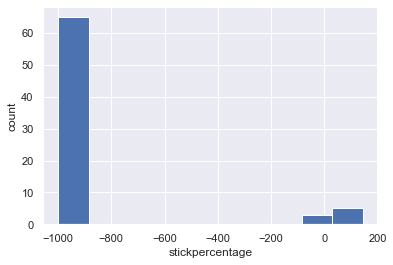

Процент пропусков: 0.0%

Детальное описание:
count     73.000000
mean    -882.923775
std      334.242024
min     -999.250000
25%     -999.250000
50%     -999.250000
75%     -999.250000
max      144.613900
Name: stickpercentage, dtype: float64

Значения признака:
-999.2500    0.890411
 25.1603     0.013699
 49.4160     0.013699
 22.4663     0.013699
 47.8994     0.013699
 95.8325     0.013699
 144.6139    0.013699
 112.4260    0.013699
 0.0000      0.013699
Name: stickpercentage, dtype: float64
Столбец esd
Распределение признака:


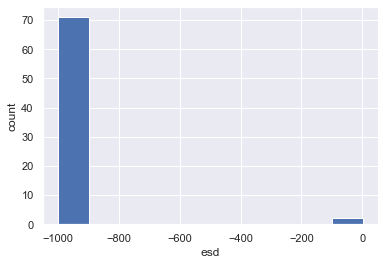

Процент пропусков: 0.0%

Детальное описание:
count     73.000000
mean    -971.838047
std      164.455856
min     -999.250000
25%     -999.250000
50%     -999.250000
75%     -999.250000
max        1.286900
Name: esd, dtype: float64

Значения признака:
-999.2500    0.972603
 1.2869      0.013699
 1.2857      0.013699
Name: esd, dtype: float64


In [244]:
for col in df3.columns:
    desription(df3, col)

Заменим NaN на 0 во всех 3х датафреймах (пропуски есть только в StuckPipe)

In [259]:
for df in [df1, df2, df3]:
    df.fillna(0, inplace = True)

Очень много данных совпадает, число 999.25 часто встречается. Необходимо больше информации о значениях признаков, чтобы сделать корректные выводы

Посмотрим, как выглядят аварии на графике

Переименуем индексы строк в даты, а столбец Дата удалим вообще

In [85]:
df11 = df1.set_index(pd.DatetimeIndex(df1['date/time']))
df11.drop(['date/time'], axis=1, inplace=True)

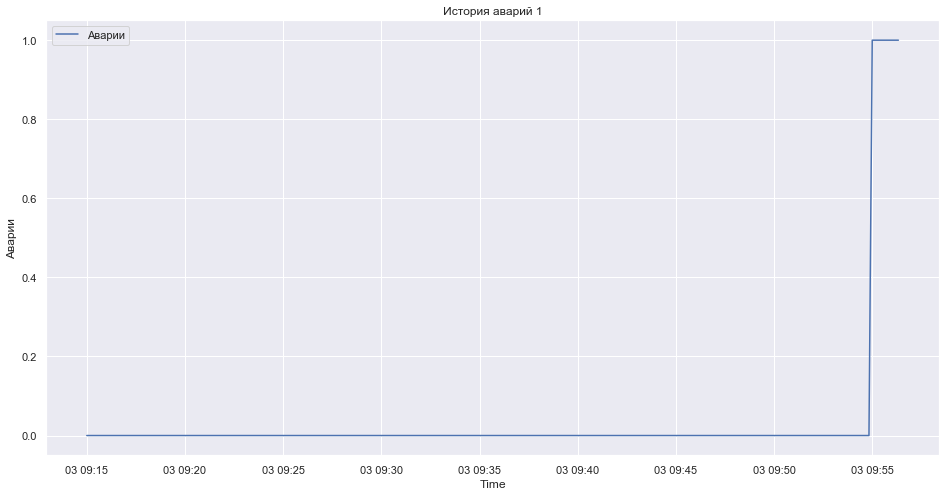

In [211]:
%matplotlib inline

plt.figure(figsize=(16, 8))

plt.plot(df11["stuckpipe"])
plt.title('История аварий 1')
plt.ylabel('Аварии')
plt.xlabel('Time')
plt.legend(['Аварии'], loc='upper left')
plt.show()

In [87]:
df22 = df2.set_index(pd.DatetimeIndex(df2['date/time']))
df22.drop(['date/time'], axis=1, inplace=True)

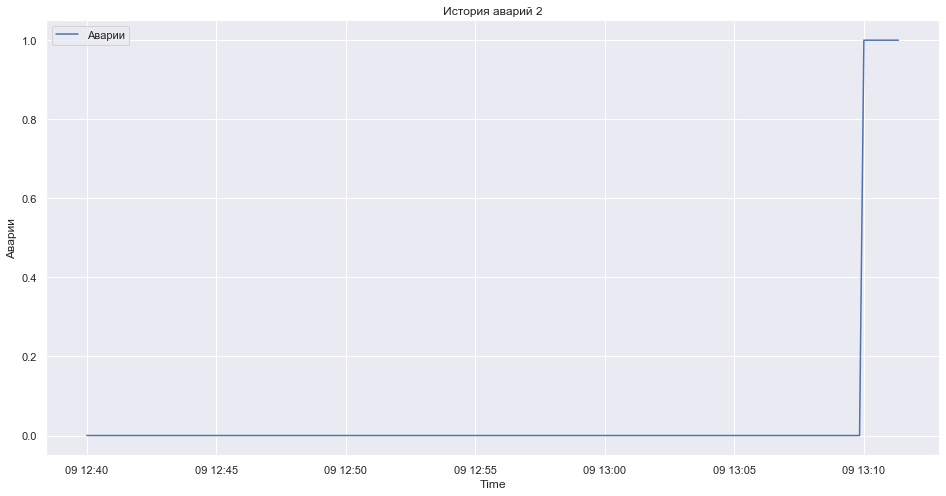

In [212]:
%matplotlib inline

plt.figure(figsize=(16, 8))

plt.plot(df22["stuckpipe"])
plt.title('История аварий 2')
plt.ylabel('Аварии')
plt.xlabel('Time')
plt.legend(['Аварии'], loc='upper left')
plt.show()

In [216]:
df33 = df3.set_index(pd.DatetimeIndex(df3['date/time']))
df33.drop(['date/time'], axis=1, inplace=True)

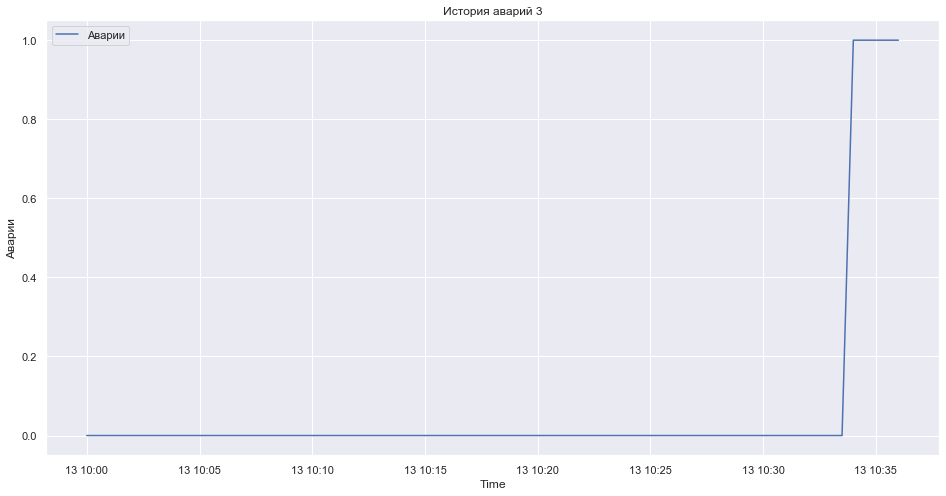

In [217]:
%matplotlib inline

plt.figure(figsize=(16, 8))

plt.plot(df33["stuckpipe"])
plt.title('История аварий 3')
plt.ylabel('Аварии')
plt.xlabel('Time')
plt.legend(['Аварии'], loc='upper left')
plt.show()

На всех графиках видно, что датафреймы содержат данные, предшествующие одной аварии

### Корреляционный анализ

In [246]:
#посмотрим на матрицу корреляции
df1.corr()

,StuckPipe,TVD,DEPT,CDEPTH,HDTH,BPOS,HKLD,STOR,FLWI,RPM,SPPA,ECD,DLS,INCL,AZIM,GR,APRS,BVEL,RIG_STATE,Stick_Slip_Ratio,StickPercentage,ESD
StuckPipe,1.000000e+00,-4.064810e-01,-4.065787e-01,-4.114698e-01,6.830343e-16,-8.463823e-02,3.800920e-02,1.756597e-01,-1.399077e-01,-2.502218e-03,-1.011643e-02,-7.334547e-02,-2.058678e-16,5.441402e-01,3.259863e-01,-6.135293e-02,-7.334450e-02,8.952862e-02,2.087384e-02,-3.853044e-03,-3.853044e-03,NaN
TVD,-4.064810e-01,1.000000e+00,9.999986e-01,9.999140e-01,-1.804305e-12,4.977823e-01,-9.959799e-02,-1.611984e-01,-4.269423e-02,-1.256497e-01,-9.662051e-02,-1.578528e-03,-1.804305e-12,-6.747836e-01,-8.966882e-01,-2.297272e-02,-6.473614e-04,5.902456e-02,-3.601716e-02,-3.607765e-02,-3.607765e-02,NaN
DEPT,-4.065787e-01,9.999986e-01,1.000000e+00,9.999177e-01,8.066435e-13,4.979082e-01,-9.902626e-02,-1.606817e-01,-4.238115e-02,-1.252231e-01,-9.622949e-02,-1.389120e-03,8.066435e-13,-6.748790e-01,-8.967562e-01,-2.259718e-02,-4.577123e-04,5.891267e-02,-3.558751e-02,-3.597894e-02,-3.597894e-02,NaN
CDEPTH,-4.114698e-01,9.999140e-01,9.999177e-01,1.000000e+00,-2.676307e-15,4.959512e-01,-9.168224e-02,-1.541870e-01,-3.309097e-02,-1.166171e-01,-8.758596e-02,8.191361e-04,-2.676307e-15,-6.757397e-01,-8.986713e-01,-1.770391e-02,1.750848e-03,5.516187e-02,-3.101408e-02,-3.360297e-02,-3.360297e-02,NaN
HDTH,6.830343e-16,-1.804305e-12,8.066435e-13,-2.676307e-15,1.000000e+00,-1.504697e-15,-7.803968e-17,-8.017531e-16,-1.797015e-16,3.681016e-15,2.135478e-16,1.642370e-15,1.000000e+00,3.067593e-11,2.127612e-11,1.014196e-15,-1.424000e-16,2.664848e-16,-3.551291e-16,6.983721e-16,6.983721e-16,NaN
BPOS,-8.463823e-02,4.977823e-01,4.979082e-01,4.959512e-01,-1.504697e-15,1.000000e+00,-1.864066e-01,-2.220054e-01,-2.382248e-01,-1.607182e-01,-2.054266e-01,-2.559521e-02,-2.263149e-15,-1.786880e-01,-4.857296e-01,-7.483439e-02,-2.438353e-02,9.443824e-02,-1.834195e-01,-3.111560e-02,-3.111560e-02,NaN
HKLD,3.800920e-02,-9.959799e-02,-9.902626e-02,-9.168224e-02,-7.803968e-17,-1.864066e-01,1.000000e+00,8.093646e-01,6.963123e-01,6.479338e-01,7.150589e-01,1.684913e-01,-2.086713e-16,1.242055e-01,-7.406786e-02,3.383998e-01,1.684837e-01,-1.971578e-01,8.336666e-01,1.643725e-01,1.643725e-01,NaN
STOR,1.756597e-01,-1.611984e-01,-1.606817e-01,-1.541870e-01,-8.017531e-16,-2.220054e-01,8.093646e-01,1.000000e+00,8.268286e-01,8.182435e-01,8.708350e-01,1.959518e-01,-7.294639e-16,2.192747e-01,-6.849428e-02,4.167516e-01,1.960144e-01,-2.253745e-01,5.310340e-01,2.073804e-01,2.073804e-01,NaN
FLWI,-1.399077e-01,-4.269423e-02,-4.238115e-02,-3.309097e-02,-1.797015e-16,-2.382248e-01,6.963123e-01,8.268286e-01,1.000000e+00,9.140581e-01,9.764272e-01,2.503542e-01,-1.899118e-16,6.050865e-02,-1.820074e-01,5.084486e-01,2.503510e-01,-3.006598e-01,3.892764e-01,2.456482e-01,2.456482e-01,NaN
RPM,-2.502218e-03,-1.256497e-01,-1.252231e-01,-1.166171e-01,3.681016e-15,-1.607182e-01,6.479338e-01,8.182435e-01,9.140581e-01,1.000000e+00,9.372737e-01,2.464057e-01,3.037945e-15,1.599606e-01,-1.439403e-01,5.200941e-01,2.467601e-01,-3.251436e-01,2.568314e-01,2.709219e-01,2.709219e-01,NaN


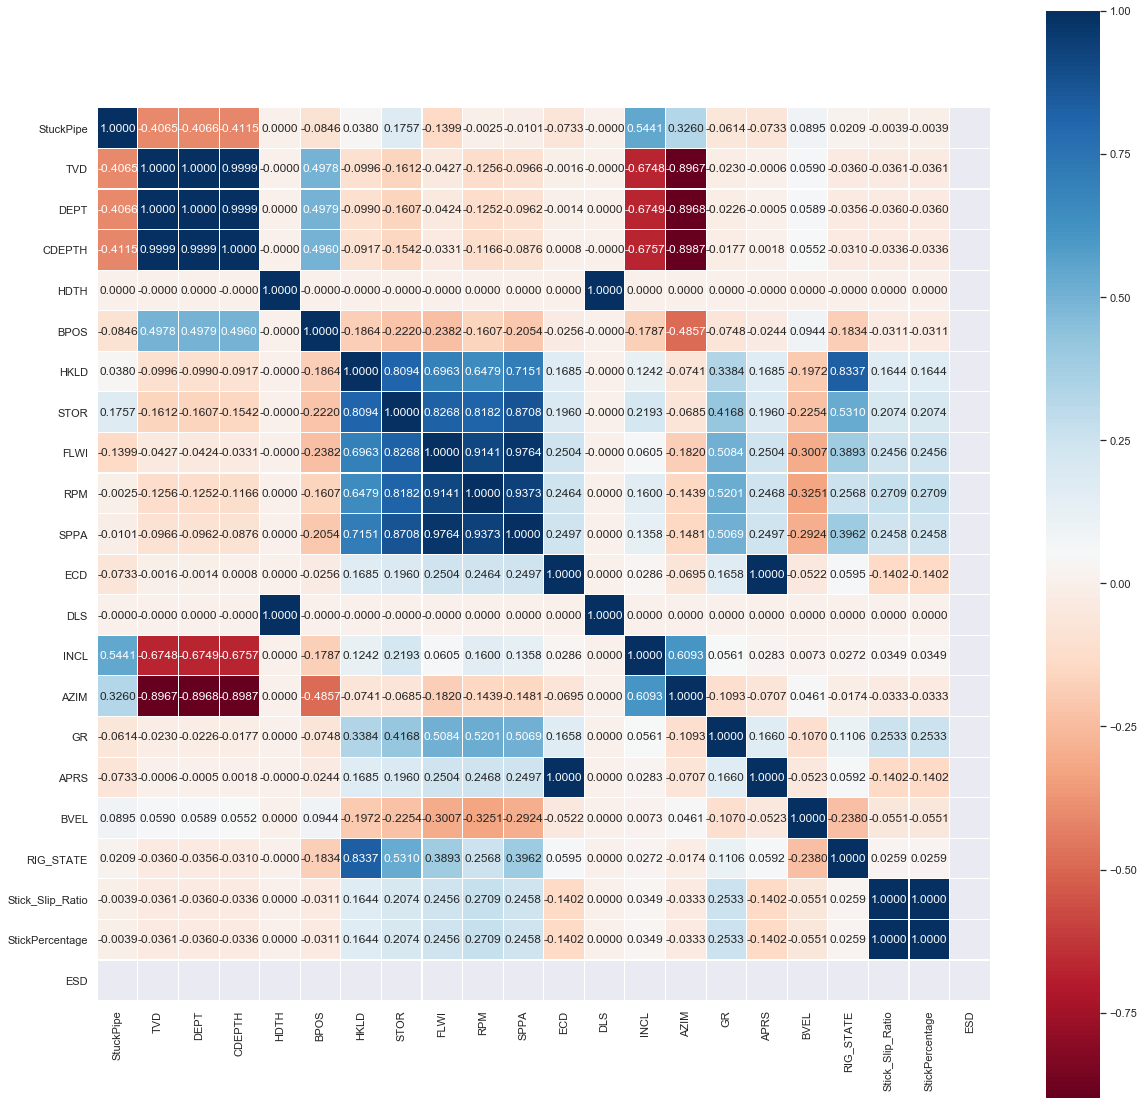

In [247]:
#строим тепловую карту 
sns.set(font_scale=1)
plt.subplots(figsize=(20, 20))
sns.heatmap(df1.corr(), square=True,
              annot=True, fmt=".4f", linewidths=0.1, cmap="RdBu")

In [248]:
#посмотрим на матрицу корреляции
df2.corr()

,StuckPipe,TVD,DEPT,CDEPTH,HDTH,BPOS,HKLD,STOR,FLWI,RPM,SPPA,ECD,DLS,INCL,AZIM,GR,APRS,BVEL,RIG_STATE,Stick_Slip_Ratio,StickPercentage,ESD
StuckPipe,1.000000e+00,3.142662e-01,-4.172636e-01,-4.255390e-01,5.865543e-16,2.042268e-01,3.703347e-02,2.340155e-01,5.020938e-02,9.857114e-03,1.916270e-01,3.860740e-03,-3.309557e-01,-5.136443e-01,5.335506e-01,-9.920221e-02,5.759328e-03,2.217790e-01,-3.823060e-03,NaN,7.984976e-02,-1.630820e-02
TVD,3.142662e-01,1.000000e+00,-9.868667e-01,-9.853366e-01,2.076820e-12,1.873278e-01,-5.187777e-02,-3.157377e-03,-5.636834e-02,-1.047769e-01,-1.062576e-02,9.105073e-03,6.129641e-01,-8.276774e-01,8.215592e-01,-1.003924e-01,9.773456e-03,1.196813e-01,-3.649875e-02,NaN,2.814689e-02,-4.782392e-02
DEPT,-4.172636e-01,-9.868667e-01,1.000000e+00,9.997938e-01,2.516823e-13,-2.024340e-01,6.150542e-03,-7.030138e-02,7.821115e-03,5.244508e-02,-5.321606e-02,-2.664775e-02,-5.457846e-01,8.961042e-01,-8.935581e-01,7.270041e-02,-2.753053e-02,-9.369311e-02,2.523267e-02,NaN,-4.536133e-02,5.065922e-02
CDEPTH,-4.255390e-01,-9.853366e-01,9.997938e-01,1.000000e+00,-1.447452e-13,-2.049441e-01,7.004538e-03,-7.213343e-02,8.665823e-03,5.160109e-02,-5.433300e-02,-2.660099e-02,-5.404339e-01,8.978286e-01,-8.955122e-01,7.187066e-02,-2.747754e-02,-9.661723e-02,2.483090e-02,NaN,-4.608541e-02,5.060492e-02
HDTH,5.865543e-16,2.076820e-12,2.516823e-13,-1.447452e-13,1.000000e+00,5.077666e-16,-2.822677e-15,-2.989381e-18,-9.097429e-16,3.829516e-16,6.870247e-16,-1.628726e-16,-6.469097e-15,-9.429791e-14,-1.943286e-15,3.005545e-16,3.781887e-16,6.209573e-17,-3.420055e-16,NaN,-6.971229e-18,1.167611e-15
BPOS,2.042268e-01,1.873278e-01,-2.024340e-01,-2.049441e-01,5.077666e-16,1.000000e+00,-3.142546e-01,-1.331798e-01,-1.932735e-01,-2.027423e-01,-8.289428e-02,8.912231e-02,-3.343384e-02,-1.342382e-01,1.395201e-01,-2.781742e-01,8.947129e-02,7.710877e-02,-3.357287e-01,NaN,6.940481e-02,-9.395836e-02
HKLD,3.703347e-02,-5.187777e-02,6.150542e-03,7.004538e-03,-2.822677e-15,-3.142546e-01,1.000000e+00,8.092763e-01,8.766248e-01,7.350340e-01,8.232249e-01,2.461043e-01,-1.175775e-01,-1.340109e-01,1.380590e-01,8.053237e-01,2.458746e-01,-6.829457e-01,6.992380e-01,NaN,1.909477e-01,5.642057e-02
STOR,2.340155e-01,-3.157377e-03,-7.030138e-02,-7.213343e-02,-2.989381e-18,-1.331798e-01,8.092763e-01,1.000000e+00,8.730987e-01,9.065142e-01,9.064794e-01,2.305050e-01,-2.010754e-01,-2.598803e-01,2.669638e-01,7.995107e-01,2.305562e-01,-7.383623e-01,3.639686e-01,NaN,2.075094e-01,-8.118762e-02
FLWI,5.020938e-02,-5.636834e-02,7.821115e-03,8.665823e-03,-9.097429e-16,-1.932735e-01,8.766248e-01,8.730987e-01,1.000000e+00,7.980999e-01,9.710338e-01,2.705053e-01,-1.130553e-01,-1.487341e-01,1.522470e-01,8.492122e-01,2.704982e-01,-6.579449e-01,4.969192e-01,NaN,1.758916e-01,4.112447e-02
RPM,9.857114e-03,-1.047769e-01,5.244508e-02,5.160109e-02,3.829516e-16,-2.027423e-01,7.350340e-01,9.065142e-01,7.980999e-01,1.000000e+00,8.106969e-01,2.521711e-01,-1.500861e-01,-1.246931e-01,1.274553e-01,8.179167e-01,2.522986e-01,-7.576048e-01,2.858761e-01,NaN,1.599051e-01,-9.092921e-02


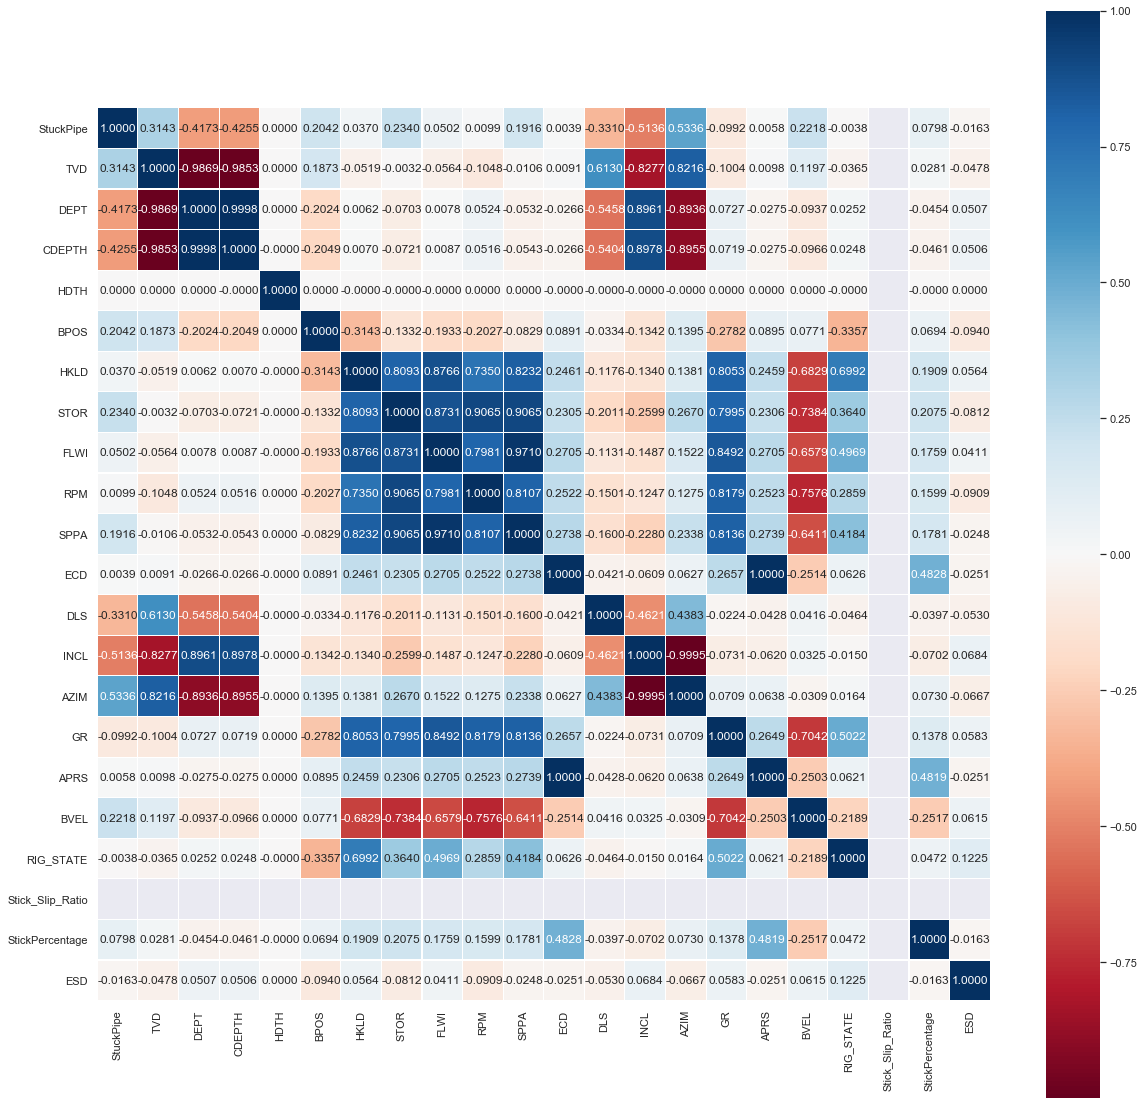

In [249]:
#строим тепловую карту 
sns.set(font_scale=1)
plt.subplots(figsize=(20, 20))
sns.heatmap(df2.corr(), square=True,
              annot=True, fmt=".4f", linewidths=0.1, cmap="RdBu")

In [250]:
#посмотрим на матрицу корреляции
df3.corr()

,stuckpipe,tvd,dept,cdepth,hdth,bpos,hkld,stor,flwi,rpm,sppa,ecd,dls,incl,azim,gr,aprs,bvel,rig_state,stick_slip_ratio,stickpercentage,esd
stuckpipe,1.000000e+00,NaN,-5.542114e-01,NaN,2.201977e-16,2.848003e-01,1.451579e-01,1.075484e-01,1.597326e-01,9.357461e-03,1.531471e-01,6.327810e-02,NaN,NaN,NaN,-1.439175e-01,6.407774e-02,4.576984e-02,1.616523e-01,-1.667937e-02,7.630342e-02,-4.551100e-02
tvd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dept,-5.542114e-01,NaN,1.000000e+00,NaN,1.149387e-13,-2.570129e-01,-1.923996e-01,-2.967260e-01,-3.061581e-01,-2.326988e-01,-2.936884e-01,-1.698472e-01,NaN,NaN,NaN,-7.993555e-02,-1.698657e-01,2.204754e-01,-1.093330e-01,-7.727117e-02,-1.579618e-01,5.438908e-02
cdepth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hdth,2.201977e-16,NaN,1.149387e-13,NaN,1.000000e+00,-4.398558e-16,1.586979e-16,5.405991e-17,1.397320e-16,1.944907e-16,-2.361630e-16,-5.084824e-16,NaN,NaN,NaN,7.572754e-17,1.345859e-16,-1.536755e-16,1.430551e-17,3.228068e-17,-1.246627e-16,1.825324e-16
bpos,2.848003e-01,NaN,-2.570129e-01,NaN,-4.398558e-16,1.000000e+00,-4.216201e-01,-6.220694e-02,-2.288380e-01,-1.546774e-01,-1.608466e-01,1.797874e-02,NaN,NaN,NaN,-3.805322e-01,1.805557e-02,3.991406e-02,-4.301593e-01,1.288458e-01,7.512896e-02,-2.016684e-01
hkld,1.451579e-01,NaN,-1.923996e-01,NaN,1.586979e-16,-4.216201e-01,1.000000e+00,4.804401e-01,7.148005e-01,4.872957e-01,6.759354e-01,2.614966e-01,NaN,NaN,NaN,6.946693e-01,2.614112e-01,-3.002218e-01,9.022154e-01,8.848845e-02,1.895063e-01,2.326066e-01
stor,1.075484e-01,NaN,-2.967260e-01,NaN,5.405991e-17,-6.220694e-02,4.804401e-01,1.000000e+00,8.041214e-01,9.621624e-01,8.547265e-01,4.466429e-01,NaN,NaN,NaN,7.565193e-01,4.464827e-01,-4.145457e-01,2.199357e-01,-3.664480e-02,3.478714e-01,-1.476543e-01
flwi,1.597326e-01,NaN,-3.061581e-01,NaN,1.397320e-16,-2.288380e-01,7.148005e-01,8.041214e-01,1.000000e+00,7.999700e-01,9.757312e-01,3.814275e-01,NaN,NaN,NaN,8.697159e-01,3.814234e-01,-3.187867e-01,5.558437e-01,1.367611e-01,3.439568e-01,8.490485e-03
rpm,9.357461e-03,NaN,-2.326988e-01,NaN,1.944907e-16,-1.546774e-01,4.872957e-01,9.621624e-01,7.999700e-01,1.000000e+00,8.487382e-01,3.978671e-01,NaN,NaN,NaN,7.903106e-01,3.974641e-01,-3.991423e-01,2.317203e-01,-2.375183e-02,3.645568e-01,-1.320406e-01


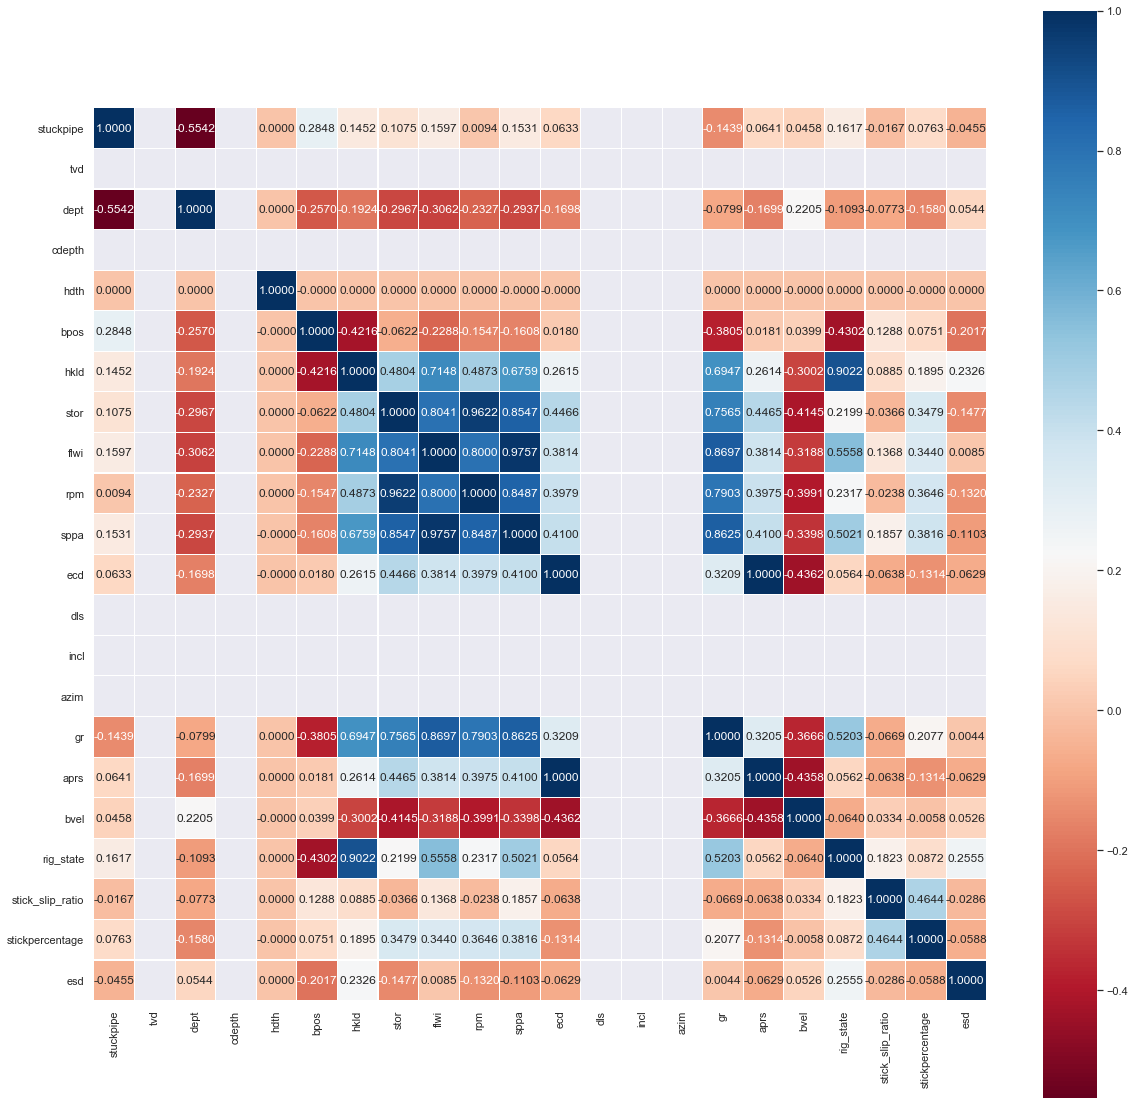

In [251]:
#строим тепловую карту 
sns.set(font_scale=1)
plt.subplots(figsize=(20, 20))
sns.heatmap(df3.corr(), square=True,
              annot=True, fmt=".4f", linewidths=0.1, cmap="RdBu")

Есть сильно скоррелированные параметры, это означает, что следует часть признаков удалить, хотя для некоторых моделей (например, случайный лес)мультиколлинеарность не является проблемой

Также в матрице есть много NaN, поскольку у нас много одинаковых значений в одном столбце

Не стоит доверять корреляционному анализу слепо и выкидывать признаки из модели. Нельзя ни в коем случае смотреть на то, как скоррелированы признаки и целевая переменная: если сильно коррелирует, то признак значимый - оставляем, если слабо - удаляем. Мы не можем просто так удалять данные, если коэфициент корреляции низкий. Если признак1 влияет в два раза слабее, чем признак2 это не повод выбрасывать признак1, он все равно значимый для модели. Для определения этого и существует t-test, и основанная на нем p-value для тестирования нулевой гипотезы, что признак1 не является значимым. 

In [111]:
# Функция для проверки статистической разницы в распределении дохода
# с помощью теста Стьюдента встроенного в функцию ttest_ind()
def get_stat_dif(column):
    # На входе имеем имя столбца с нечисловыми (номинативными) данными
    # Проверяем характер распределения оценок в зависимости от значений в этом столбце
    cols = df1.loc[:, column].value_counts().index
    # Создаём все возможные парные комбинации из элементов списка cols 
    combinations_all = list(combinations(cols, 2))
    # Для каждой пары номинативных значений рассматриваемого столбца
    # выполняем тест Стьюдента 
    for comb in combinations_all:
        # Готовим аргументы для функции ttest_ind()
        if ttest_ind(df1.loc[df1.loc[:, column] == comb[0], 'stuckpipe'], 
                        df1.loc[df1.loc[:, column] == comb[1], 'stuckpipe'], nan_policy='omit').pvalue \
            <= 0.05/len(combinations_all): 
            print('Найдены статистически значимые различия для колонки', column)
            break

In [112]:
for col in df1.columns:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки stuckpipe
Найдены статистически значимые различия для колонки tvd
Найдены статистически значимые различия для колонки dept
Найдены статистически значимые различия для колонки cdepth
Найдены статистически значимые различия для колонки bpos
Найдены статистически значимые различия для колонки rpm
Найдены статистически значимые различия для колонки incl
Найдены статистически значимые различия для колонки azim
Найдены статистически значимые различия для колонки rig_state


In [109]:
# Функция для проверки статистической разницы в распределении дохода
# с помощью теста Стьюдента встроенного в функцию ttest_ind()
def get_stat_dif(column):
    # На входе имеем имя столбца с нечисловыми (номинативными) данными
    # Проверяем характер распределения оценок в зависимости от значений в этом столбце
    cols = df2.loc[:, column].value_counts().index
    # Создаём все возможные парные комбинации из элементов списка cols 
    combinations_all = list(combinations(cols, 2))
    # Для каждой пары номинативных значений рассматриваемого столбца
    # выполняем тест Стьюдента 
    for comb in combinations_all:
        # Готовим аргументы для функции ttest_ind()
        if ttest_ind(df2.loc[df1.loc[:, column] == comb[0], 'stuckpipe'], 
                        df2.loc[df2.loc[:, column] == comb[1], 'stuckpipe'], nan_policy='omit').pvalue \
            <= 0.05/len(combinations_all): 
            print('Найдены статистически значимые различия для колонки', column)
            break

In [110]:
for col in df2.columns:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки stuckpipe
Найдены статистически значимые различия для колонки flwi
Найдены статистически значимые различия для колонки rig_state


In [254]:
# Функция для проверки статистической разницы в распределении дохода
# с помощью теста Стьюдента встроенного в функцию ttest_ind()
def get_stat_dif(column):
    # На входе имеем имя столбца с нечисловыми (номинативными) данными
    # Проверяем характер распределения оценок в зависимости от значений в этом столбце
    cols = df3.loc[:, column].value_counts().index
    # Создаём все возможные парные комбинации из элементов списка cols 
    combinations_all = list(combinations(cols, 2))
    # Для каждой пары номинативных значений рассматриваемого столбца
    # выполняем тест Стьюдента 
    for comb in combinations_all:
        # Готовим аргументы для функции ttest_ind()
        if ttest_ind(df3.loc[df3.loc[:, column] == comb[0], 'stuckpipe'], 
                        df3.loc[df3.loc[:, column] == comb[1], 'stuckpipe'], nan_policy='omit').pvalue \
            <= 0.05/len(combinations_all): 
            print('Найдены статистически значимые различия для колонки', column)
            break

In [255]:
for col in df3.columns:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки stuckpipe
Найдены статистически значимые различия для колонки dept
Найдены статистически значимые различия для колонки bpos


Судя по полученным результатам, для каждого датафрейма наборы колонок различаются, значит, на таргет влияли разные факторы

## Задание 2 

посмотрим на распределение классов таргета (stuckpipe) еще раз повнимательнее

In [95]:
df1['stuckpipe'].value_counts()

0.0    239
1.0      9
Name: stuckpipe, dtype: int64

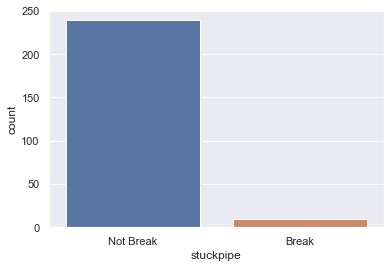

In [101]:
g = sns.countplot(df1['stuckpipe'])
g.set_xticklabels(['Not Break','Break'])
plt.show()

In [96]:
df2['stuckpipe'].value_counts()

0.0    180
1.0      9
Name: stuckpipe, dtype: int64

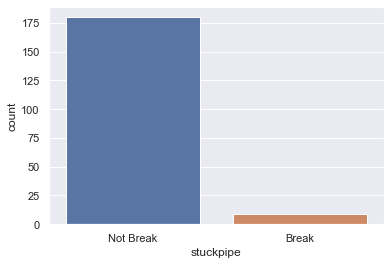

In [113]:
q = sns.countplot(df2['stuckpipe'])
q.set_xticklabels(['Not Break','Break'])
plt.show()

In [98]:
df3['StuckPipe'].value_counts()

0.0    68
1.0     5
Name: StuckPipe, dtype: int64

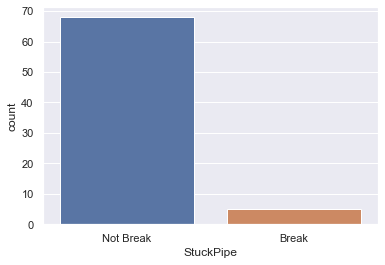

In [114]:
p = sns.countplot(df3['StuckPipe'])
p.set_xticklabels(['Not Break','Break'])
plt.show()

Поскольку у нас дисбаланс классов, построенный на таких данных классификатор скорей всего окажется неэффективным, несмотря на то, что метрика (roc auc или accuracy) будет иметь очень хорошее значение. Причем издержки ошибочной классификации, в особенности примеров миноритарного класса (в нашем случае, миноритарным классом является авария) достаточно велики.

Достаточно часто для решения проблемы несбалансированных классов применяют разные стратегии сэмплинга (случайные и специальные).

Восстановление баланса классов может проходить двумя путями. В первом случае удаляют некоторое количество примеров мажоритарного класса (undersampling - Случайное удаление примеров мажоритарного класса, Правило сосредоточенного ближайшего соседа, Односторонний сэмплинг, Правило «очищающего» соседа), во втором – увеличивают количество примеров миноритарного (oversampling - Дублирование примеров миноритарного класса, SMOTE). 

Рассмотрим комбинацию 2х стратегий: Случайное удаление примеров мажоритарного класса и SMOTE, которая основана на идее генерации некоторого количества искусственных примеров, которые были бы «похожи» на имеющиеся в миноритарном классе, но при этом не дублировали их.


### SNOTE

In [162]:
y = df1['stuckpipe'].values
X = df1.drop(['stuckpipe', 'date/time'], axis=1)

In [163]:
# посмотрим на распределение классов
counter = Counter(y)
print(counter)

Counter({0.0: 239, 1.0: 9})


In [164]:
#трансформируем датасет
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [165]:
# посмотрим на новое распределение классов
counter = Counter(y)
print(counter)

Counter({0.0: 239, 1.0: 239})


### Сочетание методов undersampling  и oversampling с использованием пайплайна

In [263]:
#обозначим таргет и признаки
y = df1['StuckPipe'].values
X = df1.drop(['StuckPipe', 'Date/Time'], axis=1)

# определяем пайплайн
model = SVC()
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under), ('model', model)]
pipeline = Pipeline(steps=steps)

# оцениваем пайплайн
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=5, n_jobs=-1)
score = mean(scores)
print('ROC AUC score for the combined sampling method: %.3f' % score)

ROC AUC score for the combined sampling method: 0.735


Попробруем поперебирать коэффициенты undersampling и oversampling и оценим полученную метрику

In [265]:
y = df1['StuckPipe'].values
X = df1.drop(['StuckPipe', 'Date/Time'], axis=1)

# значения коэффициентов
over_values = [0.3,0.4,0.5]
under_values = [0.7,0.6,0.5]
for o in over_values:
    for u in under_values:
        model = SVC()
        over = SMOTE(sampling_strategy=o)
        under = RandomUnderSampler(sampling_strategy=u)
        steps = [('over', over), ('under', under), ('model', model)]
        pipeline = Pipeline(steps=steps)
        scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=5, n_jobs=-1)
        score = mean(scores)
        print('SMOTE oversampling rate:%.1f, Random undersampling rate:%.1f , Mean ROC AUC: %.3f' % (o, u, score))


SMOTE oversampling rate:0.3, Random undersampling rate:0.7 , Mean ROC AUC: 0.744
SMOTE oversampling rate:0.3, Random undersampling rate:0.6 , Mean ROC AUC: 0.717
SMOTE oversampling rate:0.3, Random undersampling rate:0.5 , Mean ROC AUC: 0.696
SMOTE oversampling rate:0.4, Random undersampling rate:0.7 , Mean ROC AUC: 0.706
SMOTE oversampling rate:0.4, Random undersampling rate:0.6 , Mean ROC AUC: 0.715
SMOTE oversampling rate:0.4, Random undersampling rate:0.5 , Mean ROC AUC: 0.731
SMOTE oversampling rate:0.5, Random undersampling rate:0.7 , Mean ROC AUC: 0.748
SMOTE oversampling rate:0.5, Random undersampling rate:0.6 , Mean ROC AUC: 0.742
SMOTE oversampling rate:0.5, Random undersampling rate:0.5 , Mean ROC AUC: 0.735


Судя по полученным результатам, для oversampling лучший коэффициент 0,5, для undersampling - 0,7. 

Есть еще один вариант для работы с несбалансировонной выборкой - использование специальных моделей для детектирования аномалий или для анализа выживаемости. Для задания 3 попробуем это проделать